**Student**: Irene Testa

**E-mail**: i.testa@studenti.unipi.it

**Roll number**: 582061

# Midterm 3 - Assignment 3

*Fitting neural network for sequences to predict Benzene.*

Importing libraries and defining settings:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers
import keras
import keras_tuner as kt

# defining pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
# setting the random seed for reproducibility
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)
%load_ext tensorboard 

## Data Preparation

In [2]:
# loading data
data_url = 'https://raw.githubusercontent.com/iretes/ISPR/main/midterm-3/data/AirQualityUCI.csv'
data = pd.read_csv(data_url, sep=';', decimal=',')
# drop rows containing all nan
data = data.dropna(how='all', axis=0)
# drop columns containing all nan
data = data.dropna(how='all', axis=1)
# parse and merge columns 'Date' and 'Time' into 'DateTime'
data['DateTime'] = pd.to_datetime(
    data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
# drop columns 'Date' and 'Time'
data = data.drop(columns=['Date', 'Time'])
# set 'DateTime' as index
data = data.set_index(['DateTime'])
# set elements '-200' to nan
data = data.replace(-200, np.nan)
# convert data to float32
data = data.astype('float32')
# keep only columns of interest
data = data[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']]
data

PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  \
DateTime                                                                      
2004-03-10 18:00:00       1360.0         1046.0        1056.0        1692.0   
2004-03-10 19:00:00       1292.0          955.0        1174.0        1559.0   
2004-03-10 20:00:00       1402.0          939.0        1140.0        1555.0   
2004-03-10 21:00:00       1376.0          948.0        1092.0        1584.0   
2004-03-10 22:00:00       1272.0          836.0        1205.0        1490.0   
...                          ...            ...           ...           ...   
2005-04-04 10:00:00       1314.0         1101.0         539.0        1374.0   
2005-04-04 11:00:00       1163.0         1027.0         604.0        1264.0   
2005-04-04 12:00:00       1142.0         1063.0         603.0        1241.0   
2005-04-04 13:00:00       1003.0          961.0         702.0        1041.0   
2005-04-04 14:00:00       1071.0         1047.0         654.0        1129.0   

                     PT08.S5(O3)  C6H6(GT)  
DateTime                                    
2004-03-10 18:00:00       1268.0      11.9  
2004-03-10 19:00:00        972.0       9.4  
2004-03-10 20:00:00       1074.0       9.0  
2004-03-10 21:00:00       1203.0       9.2  
2004-03-10 22:00:00       1110.0       6.5  
...                          ...       ...  
2005-04-04 10:00:00       1729.0      13.5  
2005-04-04 11:00:00       1269.0      11.4  
2005-04-04 12:00:00       1092.0      12.4  
2005-04-04 13:00:00        770.0       9.5  
2005-04-04 14:00:00        816.0      11.9  

[9357 rows x 6 columns]

Defining a function for filling missing values using interpolation only when the consecutive NaNs fall below a specified threshold:

In [3]:
INTERPOLATION_LIMIT = 4
def interpolate(data, limit=INTERPOLATION_LIMIT):
    data = data.copy()
    for col in data.columns:
        mask = data[col].isna().groupby(data[col].notna().cumsum()).transform('count')<=limit+1
        data[col] = np.where(mask, data[col].interpolate(limit=limit), data[col])
    return data

Interpolating missing values using the function defined above or copying values from the previous or following day when there are more than 4 consecutive NaNs:

In [4]:
imputed_data = interpolate(data)
# copying from the previous day
prev_day = imputed_data.add(imputed_data.shift(24), fill_value=0)
imputed_data = imputed_data.combine_first(prev_day)
imputed_data = interpolate(imputed_data)
# copying from the succeeding day
succ_day = imputed_data.add(imputed_data.shift(-24), fill_value=0)
imputed_data = imputed_data.combine_first(succ_day)
imputed_data = interpolate(imputed_data)
# copying from the day before the previous day
prev_prev_day = imputed_data.add(imputed_data.shift(48), fill_value=0)
imputed_data = imputed_data.combine_first(prev_prev_day)
imputed_data = interpolate(imputed_data)
print("Percentage of missing values:")
imputed_data.isna().mean() * 100

Percentage of missing values:


PT08.S1(CO)      0.0
PT08.S2(NMHC)    0.0
PT08.S3(NOx)     0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
C6H6(GT)         0.0
dtype: float64

Plotting the time series highlighting imputed values:

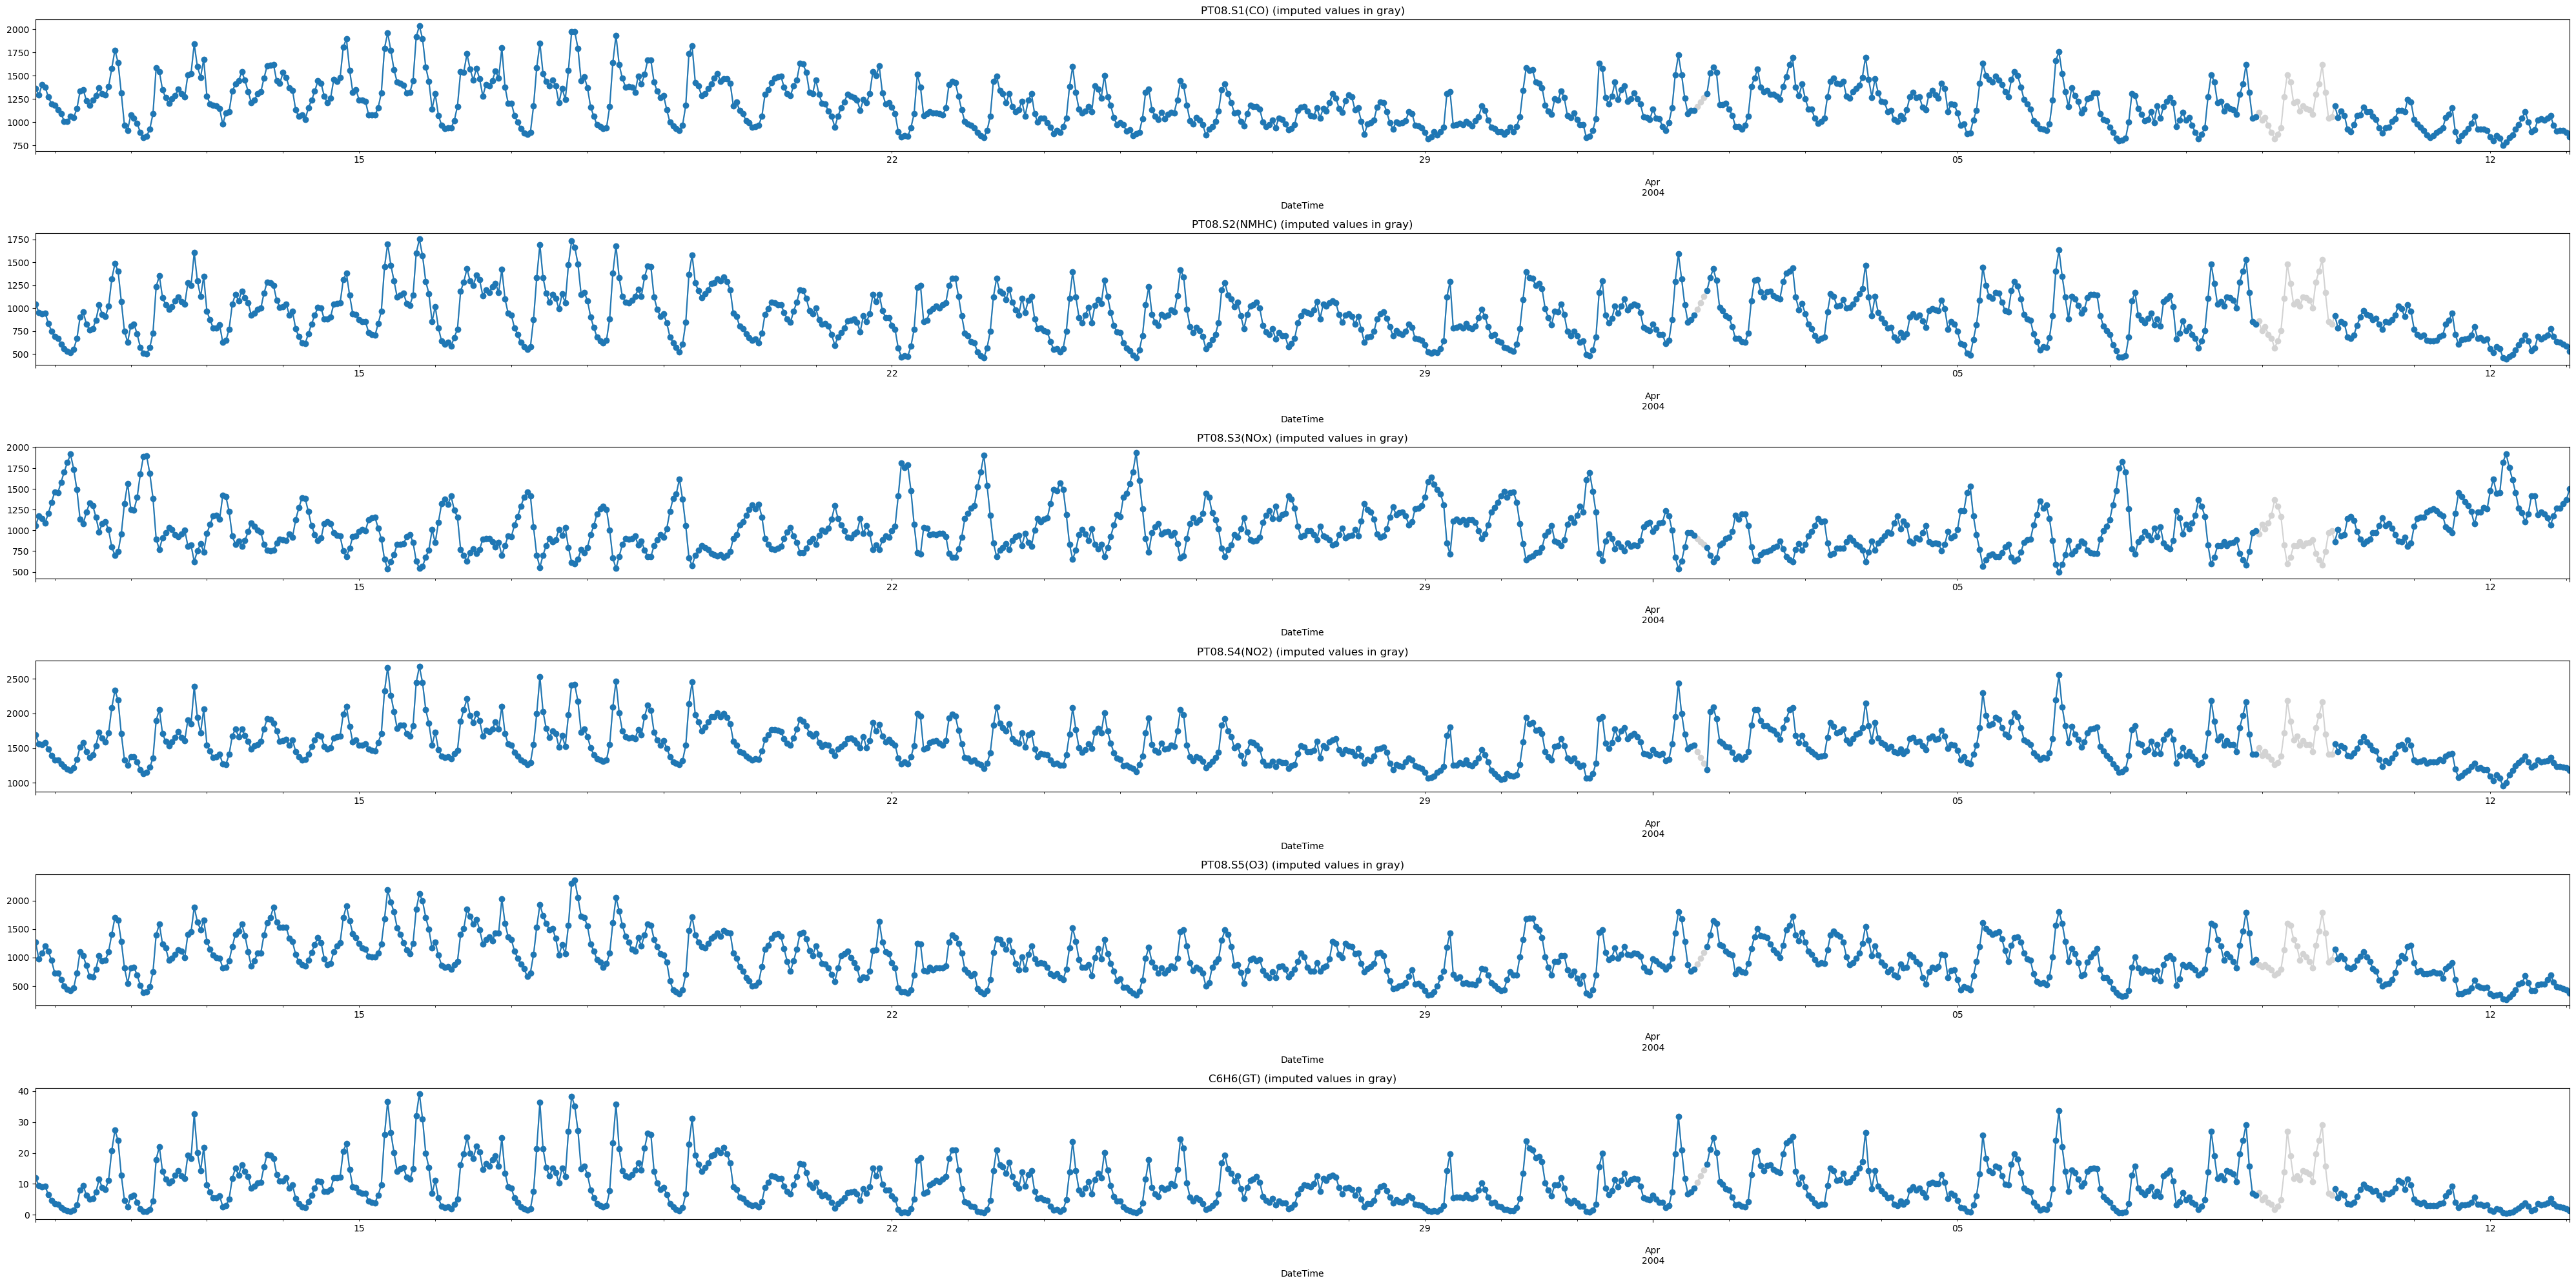

In [5]:
fig, axs = plt.subplots(len(data.columns), figsize=(40, 20))
for i, col in enumerate(data.columns):
    imputed_data[:800][col].plot(kind='line', style='-o',  ax=axs[i], color='lightgray')
    data[:800][col].plot(kind='line', style='-o',  ax=axs[i])
    axs[i].set_title(f'{col} (imputed values in gray)')
fig.tight_layout()

Data statistics:

In [6]:
data.describe()

PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
count  8991.000000    8991.000000   8991.000000   8991.000000  8991.000000   
mean   1099.833130     939.153381    835.493591   1456.264648  1022.906128   
std     217.080063     266.831543    256.817444    346.206482   398.484406   
min     647.000000     383.000000    322.000000    551.000000   221.000000   
25%     937.000000     734.500000    658.000000   1227.000000   731.500000   
50%    1063.000000     909.000000    806.000000   1463.000000   963.000000   
75%    1231.000000    1116.000000    969.500000   1674.000000  1273.500000   
max    2040.000000    2214.000000   2683.000000   2775.000000  2523.000000   

          C6H6(GT)  
count  8991.000000  
mean     10.083106  
std       7.449828  
min       0.100000  
25%       4.400000  
50%       8.200000  
75%      14.000000  
max      63.700001

Splitting the data into training, validation and test sets:

In [7]:
# from now on, use the imputed data
data = imputed_data.copy()
# defining sensors and target names
target_name = 'C6H6(GT)'
sensors_names = data.columns
sensors_names = sensors_names.drop([target_name]).to_list()
# split data
n_samples = len(data)
train_df = data[:"2004-12-1 17:00:00"] # first sample is at 18:00:00
val_df = data["2004-12-1 18:00:00":"2005-02-15 17:00:00"]
test_df = data["2005-02-15 18:00:00":]
# print sizes
print(f"Train set size (%): {(train_df.shape[0]/n_samples)*100:.2f}")
print(f"Validation set size (%): {(val_df.shape[0]/n_samples)*100:.2f}")
print(f"Test set size (%): {(test_df.shape[0]/n_samples)*100:.2f}")

Train set size (%): 68.23
Validation set size (%): 19.49
Test set size (%): 12.28


Data is split into training (around 70%), validation (around 20%) and test sets for model training, hyperparameter tuning and evaluation, respectively. Temporal sequentiality is preserved to ensure the model is tested on future data, reflecting real-world conditions. The splits are made at 18:00:00 to avoid splitting any day (the oldest sample was measured at 18:00:00).

Visualizing sensors and benzene distributions:

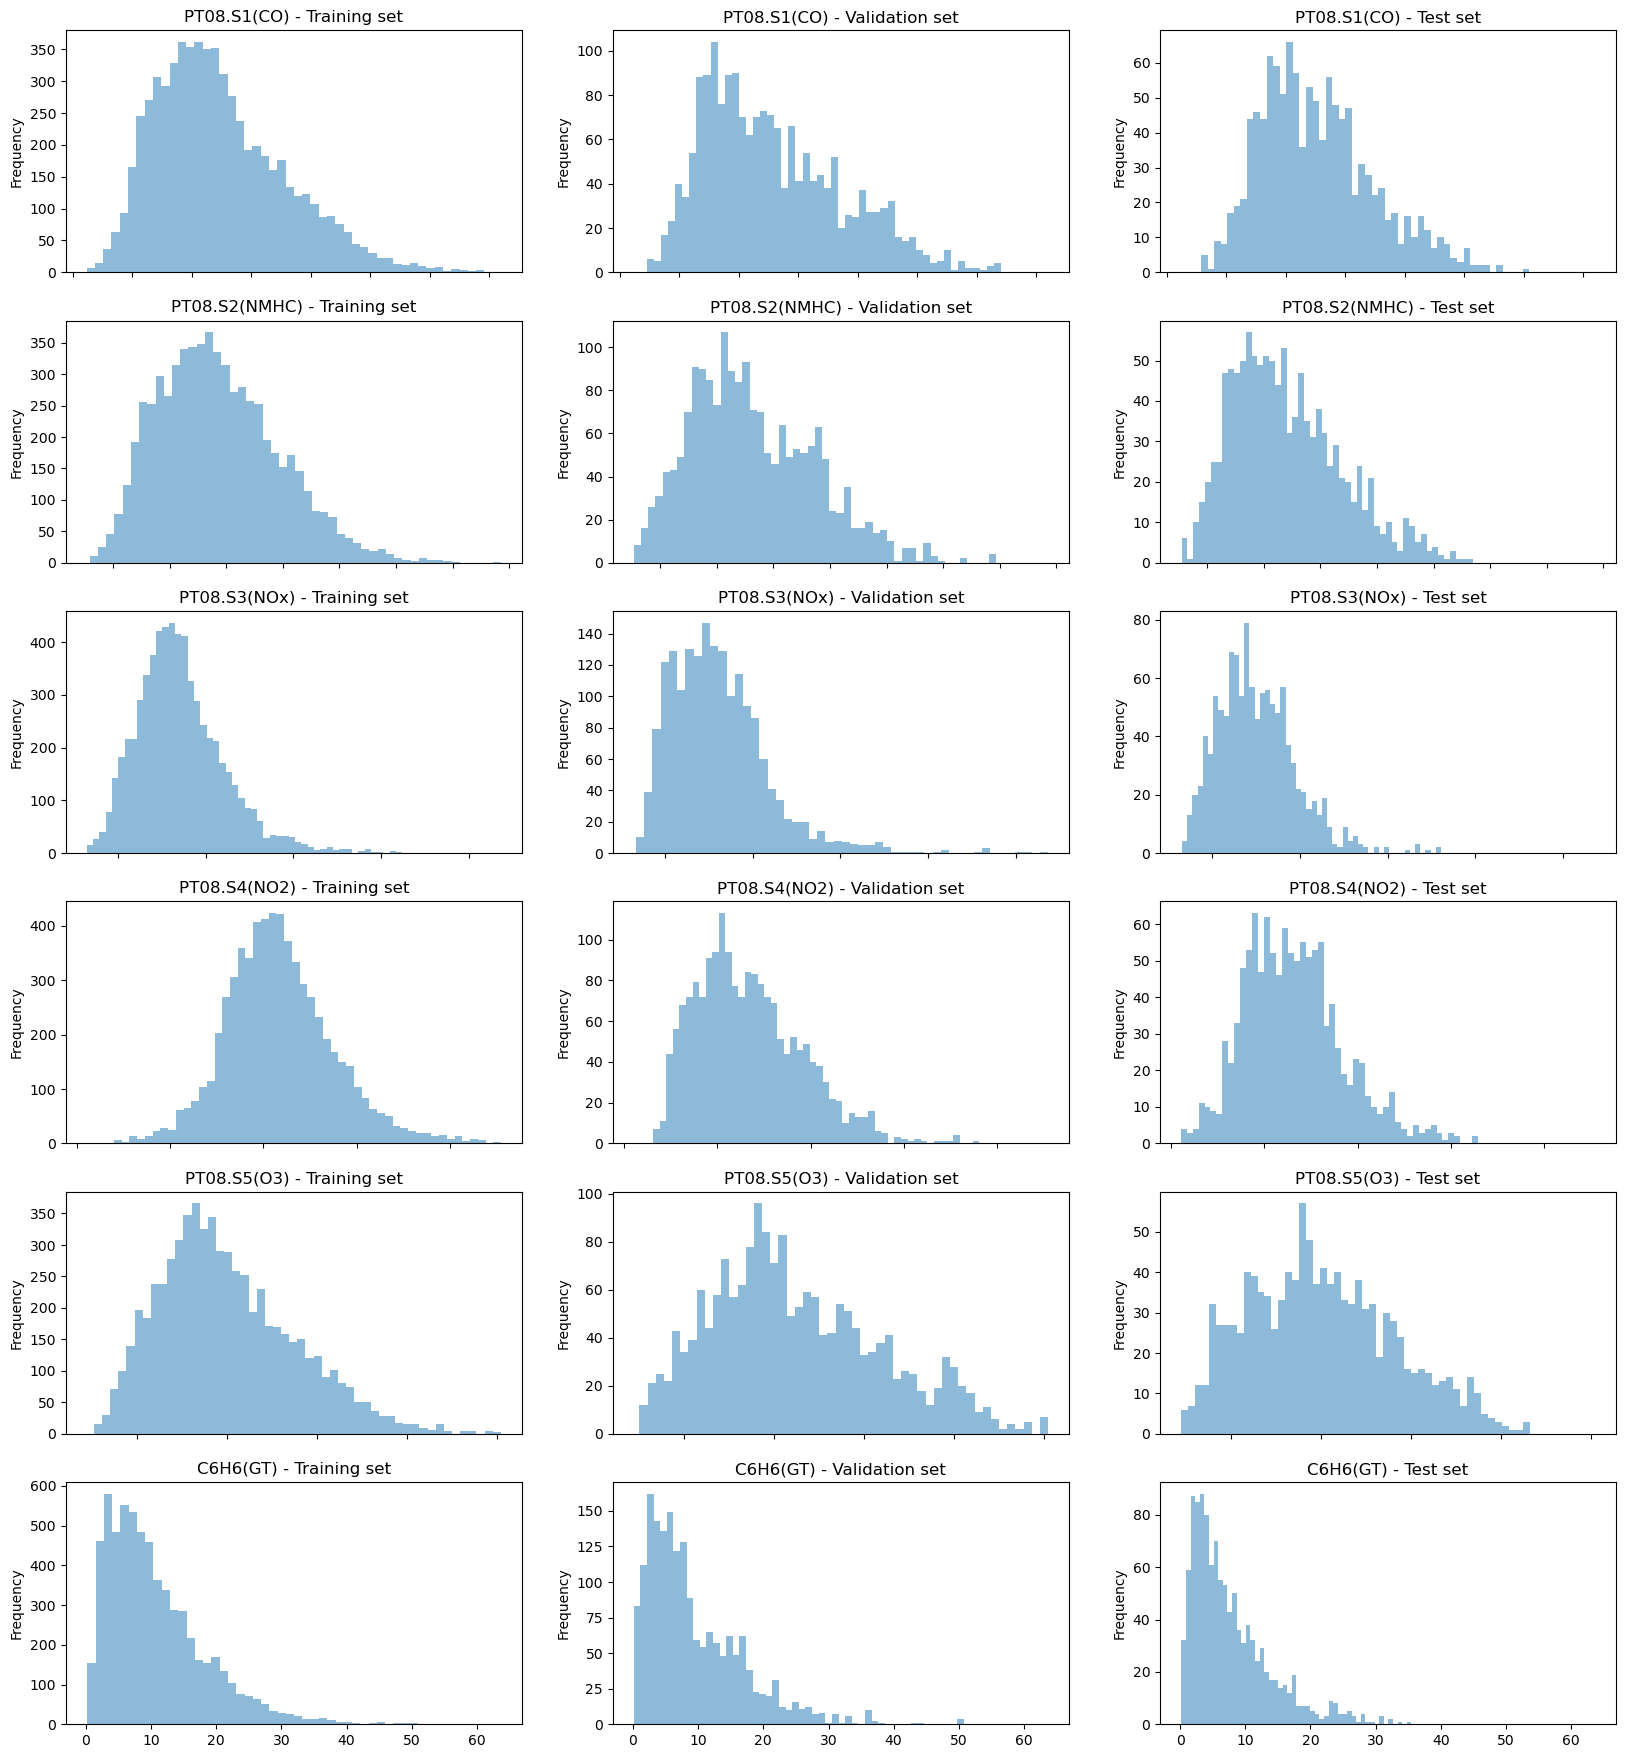

In [8]:
fig, axs = plt.subplots(len(train_df.columns), 3, figsize=(20, 22), sharex='row')
for i, set in enumerate([train_df, val_df, test_df]):
    set_name = 'Training set' if i==0 else 'Validation set' if i==1 else 'Test set'
    for j, col in enumerate(set.columns):
        set[col].plot.hist(bins=50, alpha=0.5, title=col, ax=axs[j][i])
        axs[j][i].set_title(f'{col} - {set_name}')

Sensors (PT08.* columns) mainly follow a Gaussian distribution. NO2 distribution exhibits a shift between training and test sets.

Inspecting pearson correlation between the columns:

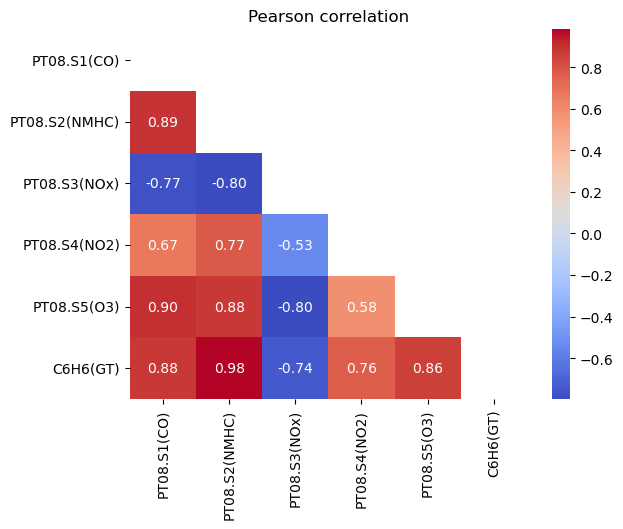

In [9]:
corr_mat = data.corr(method='pearson')
sns.heatmap(corr_mat, mask=np.triu(corr_mat), annot=True, fmt=".2f", cmap='coolwarm');
plt.title('Pearson correlation');

Sensors and target measurements are highly correlated. Sensors PT08.S1 (CO), PT08.S2 (NMHC), PT08.S4 (NO2) and PT08.S5 (O3) show a strong positive correlation with the target, whereas sensor PT08.S3 (NOx) exhibits a negative correlation with the target. This suggests that the target can be predicted using sensors measurements from the current time step if available.

Plotting auto-correlation with a lag up to one week:

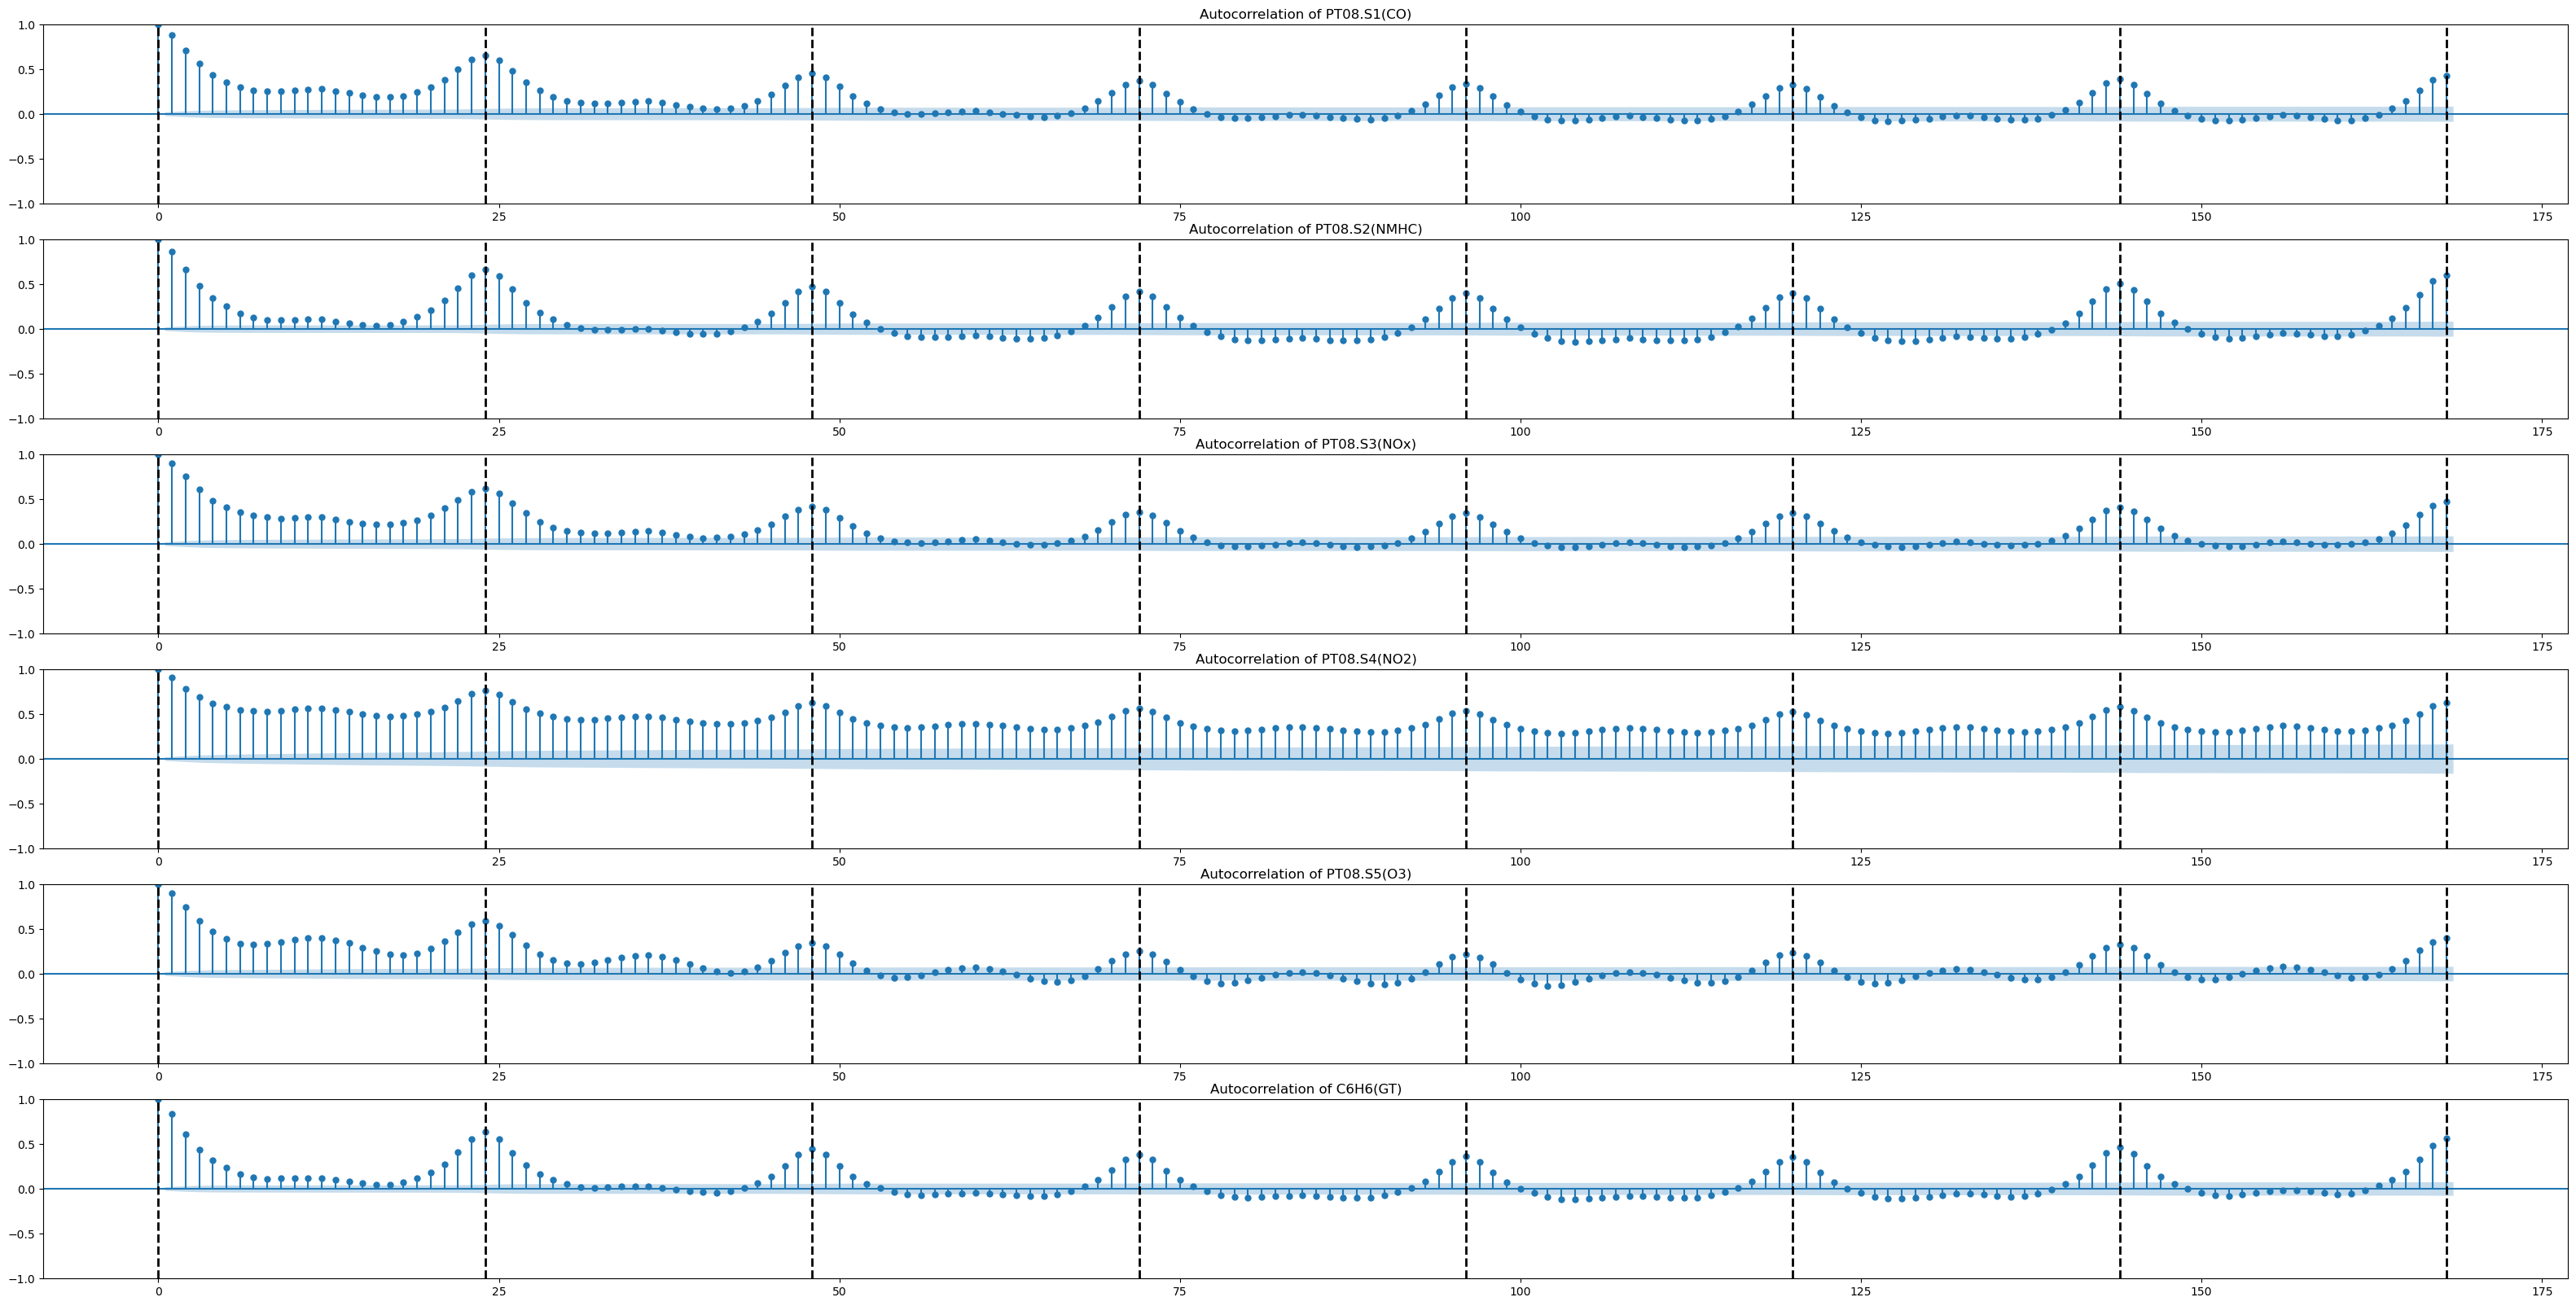

In [10]:
fig, axs = plt.subplots(len(data.columns), figsize=(40, 20))
for i, col in enumerate(data.columns):
    plot_acf(data[col], lags=24*7, ax=axs[i])
    for k in range(1, 8):
        axs[i].axvline(24*k, color='black', linestyle='--', linewidth=2)
    axs[i].axvline(0, color='black', linestyle='--', linewidth=2)
    axs[i].set_title(f'Autocorrelation of {col}')

All sensors report a peak every 24 hours, suggesting a daily pattern in the data.

Z-score normalization of sensor data:

In [11]:
scaler_sensors = StandardScaler()
sensors_train = scaler_sensors.fit_transform(train_df[sensors_names])
target_train = train_df[target_name].values
sensors_val = scaler_sensors.transform(val_df[sensors_names])
target_val = val_df[target_name].values
sensors_test = scaler_sensors.transform(test_df[sensors_names])
target_test = test_df[target_name].values

The target is not normalized to prevent inversion of the transformation when evaluating the model. To avoid data leakage, the mean and standard deviation are computed only on the training set and then used to scale the validation and test sets.

I will first model the supervised learning task as a regression problem, where the target is the Benzene concentration at the next time step (single step prediction) and each sample is a sequence of sensor measurements. The function defined below generates windows of a specified length (`time_steps`), shifting them by one time step at each iteration, thereby enabling predictions for each time step in the evaluation sets. The parameter `current_time` determines whether the target is the Benzene concentration at the current time step (`current_time=True`) or at the next time step (`current_time=False`).

In [12]:
def create_dataset_single_step(X, y, time_steps=24, current_time=False):
    Xs, ys = [], []
    for i in range(X.shape[0] - time_steps):
        if current_time:
            xi = X[i:(i + time_steps + 1)]
        else:
            xi = X[i:(i + time_steps)]
        Xs.append(xi)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

## Predicting Benzene from sensor measurements

### 1) Use of sensors measurements up to the previous hour

At first, I will use the sensor measurements in the previous 24 hours to predict the Benzene concentration at the next time step. 

Preparing the data:

In [13]:
print("Before windowing:")
print(f"sensors_train shape: {sensors_train.shape}, target_train shape: {target_train.shape}")
print(f"sensors_val shape: {sensors_val.shape}, target_val shape: {target_val.shape}")
print(f"sensors_test shape: {sensors_test.shape}, target_test shape: {target_test.shape}")

X_sensors_prev_train, y_train = create_dataset_single_step(sensors_train, target_train, time_steps=24, current_time=False)
X_sensors_prev_val, y_val = create_dataset_single_step(sensors_val, target_val, time_steps=24, current_time=False)
X_sensors_prev_test, y_test = create_dataset_single_step(sensors_test, target_test, time_steps=24, current_time=False)

print("After windowing:")
print(f"X_sensors_prev_train shape: {X_sensors_prev_train.shape}, y_train shape: {y_train.shape}")
print(f"X_sensors_prev_val shape: {X_sensors_prev_val.shape}, y_val shape: {y_val.shape}")
print(f"X_sensors_prev_test shape: {X_sensors_prev_test.shape}, y_test shape: {y_test.shape}")

Before windowing:
sensors_train shape: (6384, 5), target_train shape: (6384,)
sensors_val shape: (1824, 5), target_val shape: (1824,)
sensors_test shape: (1149, 5), target_test shape: (1149,)
After windowing:
X_sensors_prev_train shape: (6360, 24, 5), y_train shape: (6360, 1)
X_sensors_prev_val shape: (1800, 24, 5), y_val shape: (1800, 1)
X_sensors_prev_test shape: (1125, 24, 5), y_test shape: (1125, 1)


The dataset is shaped as a 3D tensor with dimensions (number of samples, number of time steps, number of features), as required by the LSTM and GRU layers in Keras. The created dataset presents 24 time steps less than the original dataset, as the first 24 samples are used to predict the 25th measurement.

For this task, I will experiment with Gated Recurrent Units (GRU) and Long Short-Term Memory (LSTM) networks. The tested models will consist of one or two LSTM or GRU layers followed by a dense layer with no activation function, as the task is a regression problem.

The hyperparameters to be tuned include the number of units in the LSTM/GRU layers (30, 40 or 50), the number of recurrent layers (1 or 2), and the recurrent model (LSTM or GRU).

In [14]:
class GatedHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # hyperparameters
        units = hp.Int(name='units', min_value=30, max_value=50, step=10)
        gated_model = hp.Choice('gated_model', values=['LSTM', 'GRU'])
        stack = hp.Boolean("stack_2_layers")
        # initializers
        init_glorot = tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)
        init_orth = tf.keras.initializers.Orthogonal(seed=RANDOM_SEED)
        # model architecture
        model = tf.keras.Sequential()
        if gated_model == 'LSTM':
            model.add(layers.LSTM(
                units=units,
                input_shape=self.input_shape,
                return_sequences=stack, # True if stacking 2 layers
                kernel_initializer=init_glorot,
                recurrent_initializer=init_orth))
        else:
            model.add(layers.GRU(
                units=units,
                input_shape=self.input_shape,
                return_sequences=stack, # True if stacking 2 layers
                kernel_initializer=init_glorot,
                recurrent_initializer=init_orth))
        if stack:
            if gated_model == 'LSTM':
                model.add(layers.LSTM(
                    units=units,
                    return_sequences=False,
                    kernel_initializer=init_glorot,
                    recurrent_initializer=init_orth))
            else:
                model.add(layers.GRU(
                    units=units,
                    return_sequences=False,
                    kernel_initializer=init_glorot,
                    recurrent_initializer=init_orth))
        model.add(layers.Dense(1, kernel_initializer=init_glorot))
        model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['mae'])
        return model

Relevant aspects of the model architecture:
- when stacking layers, `return_sequences` must be `True` in order to use all the time steps in the subsequent layer
- prediction is made only at the last time step (the last recurrent layer has `return_sequences=False`)

The models will be trained using the Adam optimizer (`learning_rate=1e-3`, `batch_size=32`) and the mean squared error loss function, with early stopping based on the validation loss (`epochs=500`, `patience=5`).

The grid search will be performed using keras-tuner, selecting the best model based on the validation loss.

In [15]:
hyper_lstm_sensors_prev = GatedHyperModel(input_shape=(X_sensors_prev_train.shape[1], X_sensors_prev_train.shape[2]))

tuner_sensors_prev = kt.GridSearch(
    hyper_lstm_sensors_prev,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

tuner_sensors_prev.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
gated_model (Choice)
{'default': 'LSTM', 'conditions': [], 'values': ['LSTM', 'GRU'], 'ordered': False}
stack_2_layers (Boolean)
{'default': False, 'conditions': []}


Running grid search:

In [16]:
tuner_sensors_prev.search(
    X_sensors_prev_train,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_sensors_prev_val, y_val),
    callbacks=[early_stopping, tensorboard_callback]
)

Trial 12 Complete [00h 00m 31s]
val_loss: 10.448738098144531

Best val_loss So Far: 10.241204261779785
Total elapsed time: 00h 04m 23s


Inspecting grid search results on tensorboard:

In [18]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8430), started 0:00:02 ago. (Use '!kill 8430' to kill it.)

Learning curves are smooth and all models converge before 70 epochs.

Defining a function to display grid search results:

In [19]:
def get_traials_df(tuner):
    trials = tuner.oracle.get_best_trials(num_trials=10000)
    hps = []
    for trial in trials:
        hps.append(trial.hyperparameters.get_config()["values"] | {"val_loss": trial.score})
    hp_df = pd.DataFrame(hps)
    hp_df = hp_df.sort_values(by='val_loss')
    return hp_df.style.background_gradient(cmap='Blues', subset=['val_loss'])

In [20]:
get_traials_df(tuner_sensors_prev)

The best model consists of two LSTM layers with 40 units each.

Getting best model:

In [21]:
results = {}
models_names = []
model_name = 'Recurrent_Sensors_t-24_t-1'
models_names.append(model_name)
results[model_name] = {}
model = tuner_sensors_prev.get_best_models()[0]
results[model_name]['fitted_model'] = model
results[model_name]['params'] = tuner_sensors_prev.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Recurrent_Sensors_t-24_t-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 40)            7360      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,361
Trainable params: 20,361
Non-trainable params: 0
_________________________________________________________________


Defining a function to evaluate the model:

In [22]:
def evaluate_model(model, X_train=None, y_train=None, X_val=None, y_val=None, X_test=None, y_test=None):
    scores = {}
    if X_train is not None and y_train is not None:
        train_scores = model.evaluate(X_train, y_train, return_dict=True)
        scores['train_mae'] = train_scores['mae']
        scores['train_loss'] = train_scores['loss']
    if X_val is not None and y_val is not None:
        val_scores = model.evaluate(X_val, y_val, return_dict=True)
        scores['val_mae'] = val_scores['mae']
        scores['val_loss'] = val_scores['loss']
    if X_test is not None and y_test is not None:
        test_scores = model.evaluate(X_test, y_test, return_dict=True)
        scores['test_mae'] = test_scores['mae']
        scores['test_loss'] = test_scores['loss']
    return scores

Evaluating the model:

In [23]:
scores = evaluate_model(
    model,
    X_train=X_sensors_prev_train, y_train=y_train,
    X_val=X_sensors_prev_val, y_val=y_val,
    X_test=X_sensors_prev_test, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 2ms/step - loss: 8.8261 - mae: 2.0232


Recurrent_Sensors_t-24_t-1
train_mae                    1.934353
val_mae                      2.093378
test_mae                     2.023213
train_loss                   8.478454
val_loss                    10.241204
test_loss                    8.826072

The model achieves a mean absolute error around 2 on both training, validation and test sets. Please note that the target range is between 0 and around 35 on the test set (around 60 on the whole time series), so the model is able to predict the target with a mean absolute error of less than 6% of the target range.

Defining functions to plot the model predictions:

In [24]:
def plot_test_predictions(true, predicted, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharey=False)
    df = pd.DataFrame(data={'actual': true.flatten(), 'predicted': predicted.flatten()})
    df.plot(ax=axs[0], color=['tab:blue', 'tab:red'], alpha=0.5)
    axs[0].set_title(f"{model_name}\nPredictions vs Actual Benzene Values on Test set")
    df['actual'][:24*7].plot(ax=axs[1], style='o', color='white', markeredgecolor='k', markersize=8)
    df['predicted'][:24*7].plot(ax=axs[1], style='X', color='red', markeredgecolor='k', markersize=8)
    for i in range(24*7):
        axs[1].axvline(i, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axs[1].set_title(f"{model_name}\nPredictions vs Actual Benzene Values (zoom on first week of test set)")
    axs[1].legend();
    fig.tight_layout()

def plot_true_vs_predicted(true, predicted, title=None):
    xy = np.vstack([true, predicted])
    kernel = gaussian_kde(xy)(xy)
    plt.figure(figsize=(5, 3))
    plt.scatter(true, predicted, c=kernel, cmap="winter")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='k', linestyle='--')
    plt.tight_layout()
    if title:
        plt.title(title)
    plt.show()

Plotting model predictions:

36/36 [==============================] - 0s 2ms/step


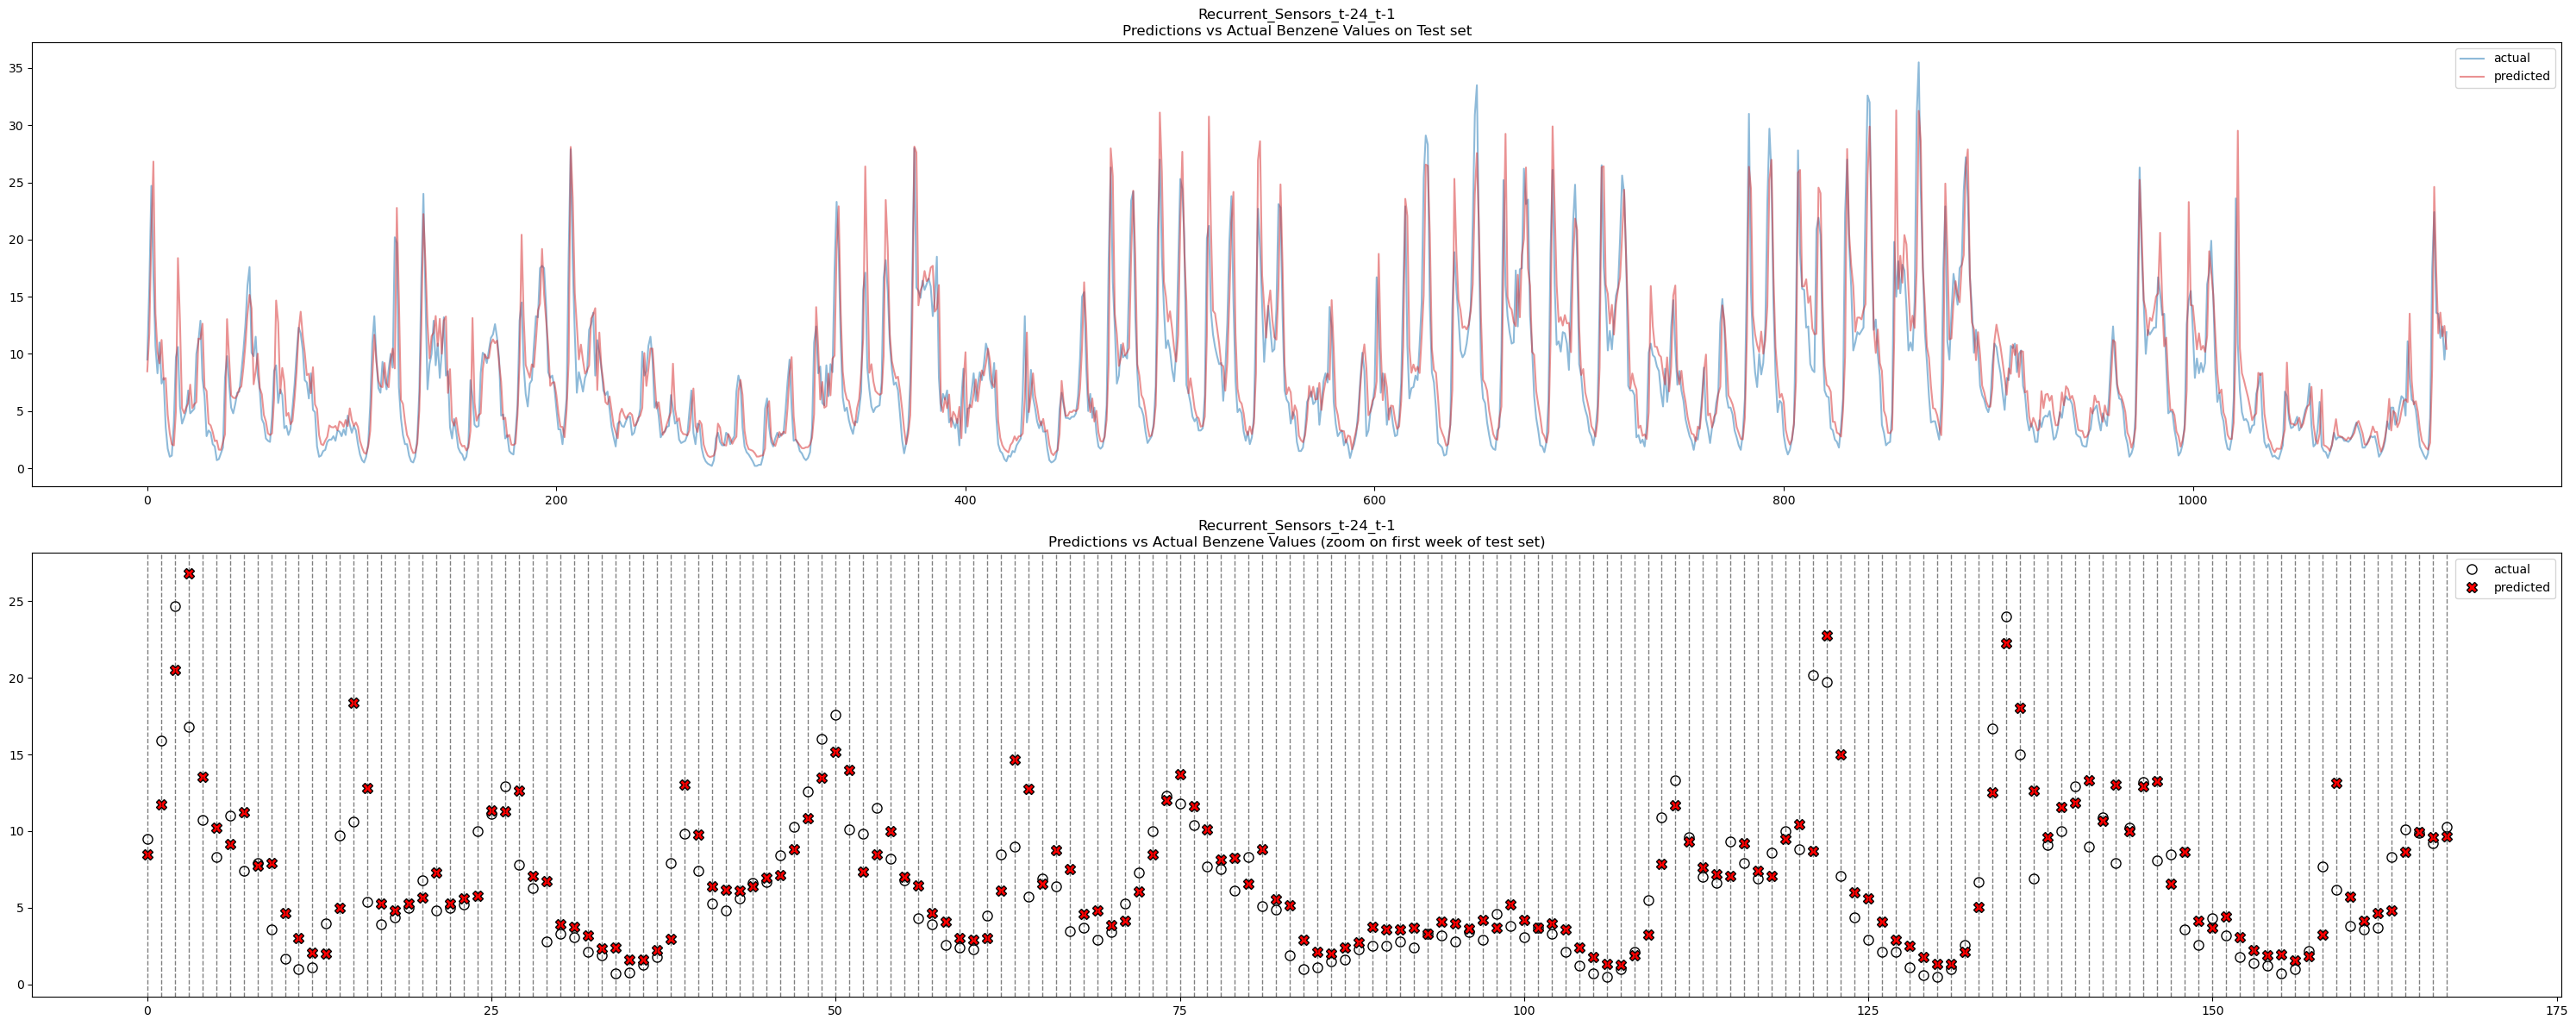

In [25]:
test_predictions = model.predict(X_sensors_prev_test)
plot_test_predictions(true=y_test, predicted=test_predictions, model_name=model_name)

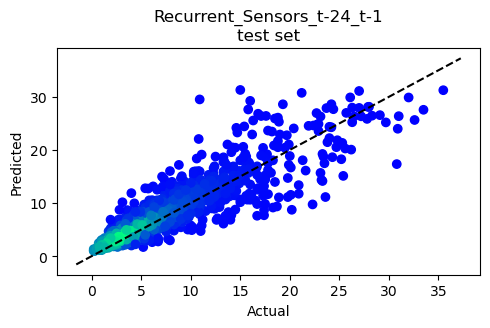

In [26]:
plot_true_vs_predicted(true=y_test.reshape(-1), predicted=test_predictions.reshape(-1), title=model_name+'\ntest set')

Defining a function to plot MAE grouped by hour and day of the week:

In [27]:
def compute_mae(group):
    return mean_absolute_error(group['actual'], group['predicted'])

def plot_MAE_grouped(actual, predicted, index):
    fig, axs = plt.subplots(2, 2, figsize=(20, 9))
    true_predicted_df = pd.DataFrame(
        data={'actual': actual, 'predicted':predicted},
        index=index
    )

    mae_by_hour = true_predicted_df.groupby(by=lambda x: x.hour).apply(compute_mae)
    mae_by_hour.plot(
        kind='bar', title='MAE by hour of the day on test set',
        xlabel='Hour of the day', ylabel='MAE',
        ax=axs[0][0], color=['gray'], alpha=0.7
    );

    mae_by_dayofweek = true_predicted_df.groupby(by=lambda x: x.dayofweek).apply(compute_mae)
    mae_by_dayofweek.plot(
        kind='bar', title='MAE by day of the week on test set',
        xlabel='Day of the week', ylabel='MAE',
        ax=axs[0][1], color=['gray'], alpha=0.7
    );

    mean_by_hour = true_predicted_df.groupby(by=lambda x: x.hour).mean()
    mean_by_hour.plot(
        kind='bar', title='Mean actual values by hour of the day on test set',
        xlabel='Hour of the day', ylabel='Mean actual value',
        ax=axs[1][0], color=['tab:blue', 'tab:red'], alpha=0.8
    );

    mean_by_dayofweek = true_predicted_df.groupby(by=lambda x: x.dayofweek).mean()
    mean_by_dayofweek.plot(
        kind='bar', title='Mean actual values by day of the week on test set',
        xlabel='Day of the week', ylabel='Mean actual value',
        ax=axs[1][1], color=['tab:blue', 'tab:red'], alpha=0.8
    );

    fig.tight_layout()

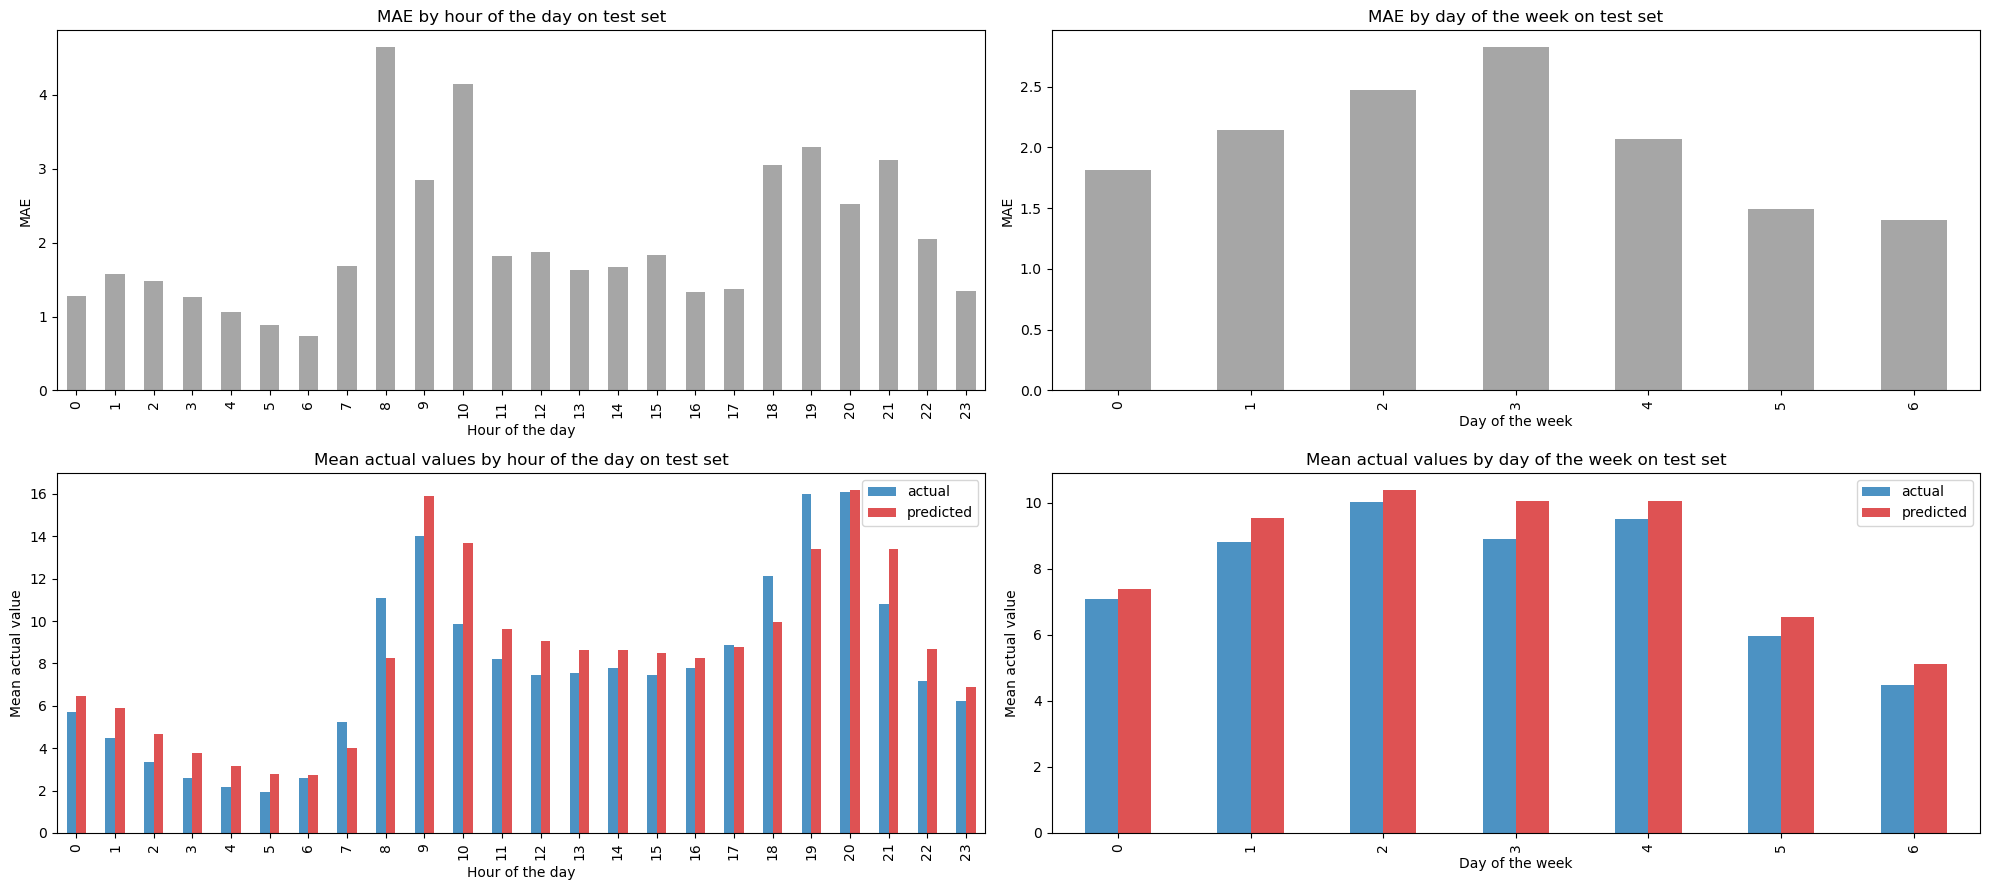

In [28]:
plot_MAE_grouped(y_test.reshape(-1), test_predictions.reshape(-1), test_df.index[24:])

The model underestimates the target at 8 am and overestimates it at 10 am. The model performs better on weekends than on weekdays.

I will now repeat the same procedure using the sensor measurements in the previous 48 hours to predict the Benzene concentration at the next time step.

Preparing the data:

In [29]:
X_sensors_48_prev_train, y_train_48 = create_dataset_single_step(sensors_train, target_train, time_steps=48, current_time=False)
X_sensors_48_prev_val, y_val_48 = create_dataset_single_step(sensors_val, target_val, time_steps=48, current_time=False)
X_sensors_48_prev_test, y_test_48 = create_dataset_single_step(sensors_test, target_test, time_steps=48, current_time=False)

print(f"X_sensors_48_prev_train shape: {X_sensors_48_prev_train.shape}, y_train_48 shape: {y_train_48.shape}")
print(f"X_sensors_48_prev_val shape: {X_sensors_48_prev_val.shape}, y_val_48 shape: {y_val_48.shape}")
print(f"X_sensors_48_prev_test shape: {X_sensors_48_prev_test.shape}, y_test_48 shape: {y_test_48.shape}")

X_sensors_48_prev_train shape: (6336, 48, 5), y_train_48 shape: (6336, 1)
X_sensors_48_prev_val shape: (1776, 48, 5), y_val_48 shape: (1776, 1)
X_sensors_48_prev_test shape: (1101, 48, 5), y_test_48 shape: (1101, 1)


Running the grid search:

In [30]:
hyper_lstm_sensors_48_prev = GatedHyperModel(input_shape=(X_sensors_48_prev_train.shape[1], X_sensors_48_prev_train.shape[2]))

tuner_sensors_48_prev = kt.GridSearch(
    hyper_lstm_sensors_48_prev,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner_sensors_48_prev.search(
    X_sensors_48_prev_train,
    y_train_48,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_sensors_48_prev_val, y_val_48),
    callbacks=[early_stopping, tensorboard_callback],
)

Trial 12 Complete [00h 00m 48s]
val_loss: 10.167247772216797

Best val_loss So Far: 9.740391731262207
Total elapsed time: 00h 06m 12s


Inspecting grid search results:

In [31]:
get_traials_df(tuner_sensors_48_prev)

This time the best model consists of a single GRU layer with 50 units.

Getting best model:

In [32]:
model_name = 'Recurrent_Sensors_t-48_t-1'
models_names.append(model_name)
results[model_name] = {}
model = tuner_sensors_48_prev.get_best_models()[0]
results[model_name]['fitted_model'] = model
results[model_name]['params'] = tuner_sensors_48_prev.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Recurrent_Sensors_t-48_t-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8550      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8,601
Trainable params: 8,601
Non-trainable params: 0
_________________________________________________________________


Evaluating the model:

In [33]:
scores = evaluate_model(
    model,
    X_train=X_sensors_48_prev_train, y_train=y_train_48,
    X_val=X_sensors_48_prev_val, y_val=y_val_48,
    X_test=X_sensors_48_prev_test, y_test=y_test_48
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

35/35 [==============================] - 0s 1ms/step - loss: 7.8151 - mae: 1.8269


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1
train_mae                    1.934353                    1.93701
val_mae                      2.093378                   2.083809
test_mae                     2.023213                   1.826876
train_loss                   8.478454                    8.11711
val_loss                    10.241204                   9.740392
test_loss                    8.826072                   7.815091

Since the use of sensor measurements in the previous 48 hours only slightly improves the model performance, in the following I will use windows of 24 hours. For this specific task, the power of recurrent models is not fully exploited, as the target can be predicted with a fairly high accuracy by looking only at the previous 24 hours of measurements.

### 2) Use of sensors measurements up to the current hour

I will now use the sensor measurements in the previous 24 hours and at the current time, to predict the Benzene concentration at the present time step.

Preparing the data:

In [34]:
X_sensors_curr_train, y_train = create_dataset_single_step(sensors_train, target_train, time_steps=24, current_time=True)
X_sensors_curr_val, y_val = create_dataset_single_step(sensors_val, target_val, time_steps=24, current_time=True)
X_sensors_curr_test, y_test = create_dataset_single_step(sensors_test, target_test, time_steps=24, current_time=True)

print(f"X_sensors_curr_train shape: {X_sensors_curr_train.shape}, y_train shape: {y_train.shape}")
print(f"X_sensors_curr_val shape: {X_sensors_curr_val.shape}, y_val shape: {y_val.shape}")
print(f"X_sensors_curr_test shape: {X_sensors_curr_test.shape}, y_test shape: {y_test.shape}")

X_sensors_curr_train shape: (6360, 25, 5), y_train shape: (6360, 1)
X_sensors_curr_val shape: (1800, 25, 5), y_val shape: (1800, 1)
X_sensors_curr_test shape: (1125, 25, 5), y_test shape: (1125, 1)


Running the grid search:

In [35]:
hyper_lstm_sensors_curr = GatedHyperModel(input_shape=(X_sensors_curr_train.shape[1], X_sensors_curr_train.shape[2]))

tuner_sensors_curr = kt.GridSearch(
    hyper_lstm_sensors_curr,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner_sensors_curr.search(
    X_sensors_curr_train,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_sensors_curr_val, y_val),
    callbacks=[early_stopping, tensorboard_callback],
)

Trial 12 Complete [00h 01m 17s]
val_loss: 0.004794782493263483

Best val_loss So Far: 0.0026562924031168222
Total elapsed time: 00h 11m 16s


Inspecting grid search results:

In [36]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8430), started 0:22:30 ago. (Use '!kill 8430' to kill it.)

In [37]:
get_traials_df(tuner_sensors_curr)

The best model consists of two LSTM layers with 50 units each.

Getting best model:

In [38]:
model_name = 'Recurrent_Sensors_t-24_t'
models_names.append(model_name)
results[model_name] = {}
model = tuner_sensors_curr.get_best_models()[0]
results[model_name]['fitted_model'] = model
results[model_name]['params'] = tuner_sensors_curr.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Recurrent_Sensors_t-24_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


Evaluating the model:

In [39]:
scores = evaluate_model(
    model,
    X_train=X_sensors_curr_train, y_train=y_train,
    X_val=X_sensors_curr_val, y_val=y_val,
    X_test=X_sensors_curr_test, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0426


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1  \
train_mae                    1.934353                    1.93701   
val_mae                      2.093378                   2.083809   
test_mae                     2.023213                   1.826876   
train_loss                   8.478454                    8.11711   
val_loss                    10.241204                   9.740392   
test_loss                    8.826072                   7.815091   

           Recurrent_Sensors_t-24_t  
train_mae                  0.033147  
val_mae                    0.037205  
test_mae                   0.042555  
train_loss                 0.007919  
val_loss                   0.002656  
test_loss                  0.002903

36/36 [==============================] - 0s 2ms/step


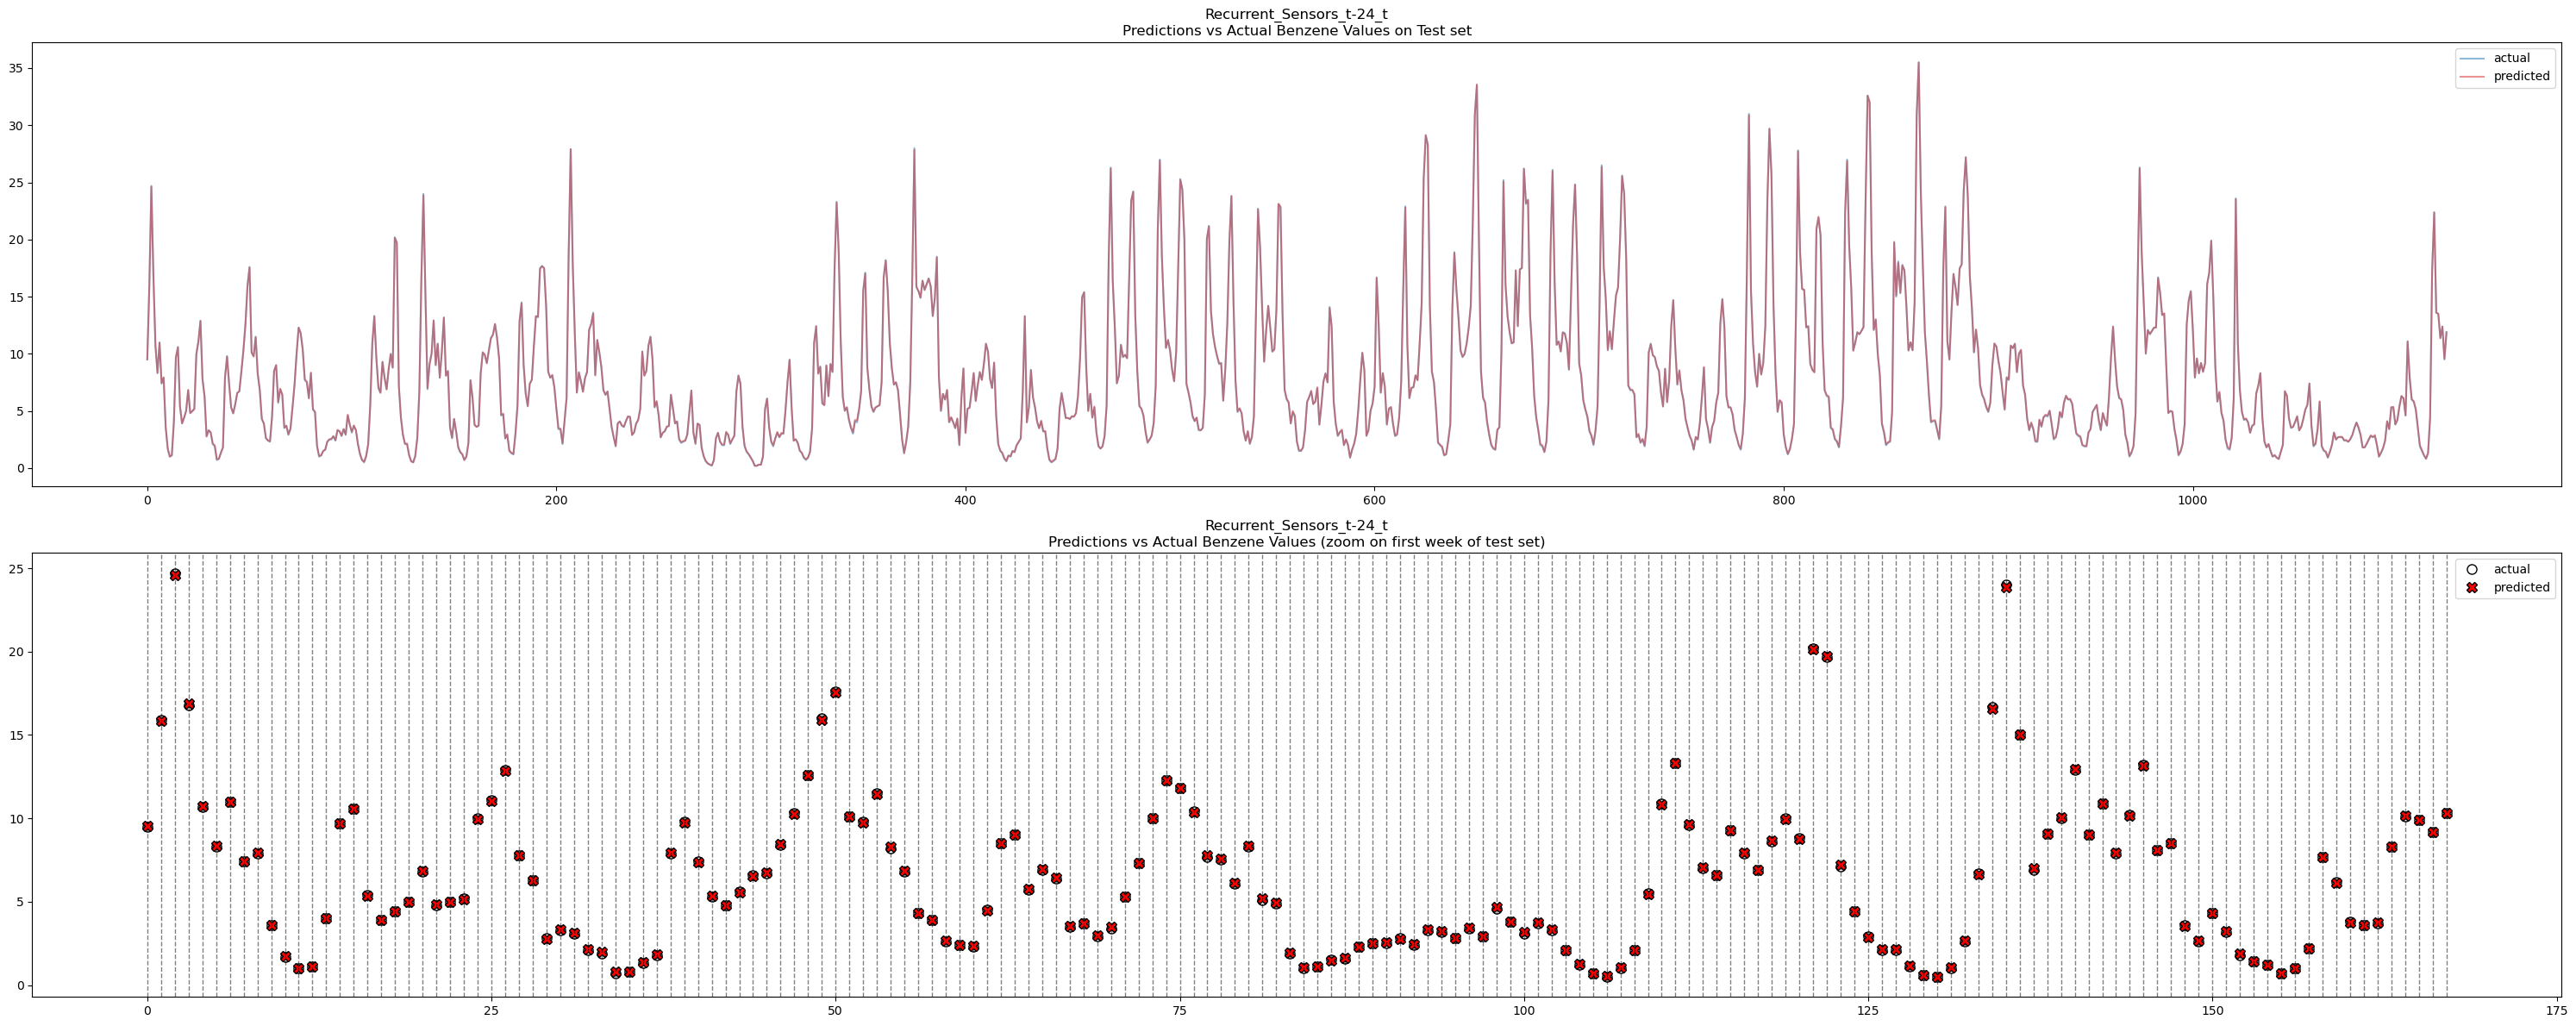

In [40]:
test_predictions = model.predict(X_sensors_curr_test)
plot_test_predictions(true=y_test, predicted=test_predictions, model_name=model_name)

This model achieves very low mean absolute errors on both training, validation and test sets.
Having access to the current sensor measurements allows the model to predict the target almost perfectly.

## Predicting Benzene at time t from Benzene up to time t-1

### Baseline model

For this task I will use as a baseline the model that predicts the Benzene concentration at the current time step as the Benzene concentration at the previous time step:

In [41]:
class Baseline(tf.keras.Model):

  def __init__(self):
    super().__init__()

  def call(self, inputs):
    return inputs[:,-1,:]

Preparing the data (without scaling the sensor measurements):

In [42]:
X_benzene_raw_train, y_train = create_dataset_single_step(train_df[[target_name]], target_train, time_steps=24, current_time=False)
X_benzene_raw_val, y_val = create_dataset_single_step(val_df[[target_name]], target_val, time_steps=24, current_time=False)
X_benzene_raw_test, y_test = create_dataset_single_step(test_df[[target_name]], target_test, time_steps=24, current_time=False)

Computing baseline performance:

In [43]:
model_name = 'Baseline_Benzene'
models_names.append(model_name)
results[model_name] = {}
model = Baseline()
model.compile(loss='mse', metrics=['mae'])
results[model_name]['fitted_model'] = model
results[model_name]['params'] = {}
model._name = model_name
scores = evaluate_model(
    model,
    X_train=X_benzene_raw_train, y_train=y_train,
    X_val=X_benzene_raw_val, y_val=y_val,
    X_test=X_benzene_raw_test, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 284us/step - loss: 14.1637 - mae: 2.3624


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1  \
train_mae                    1.934353                    1.93701   
val_mae                      2.093378                   2.083809   
test_mae                     2.023213                   1.826876   
train_loss                   8.478454                    8.11711   
val_loss                    10.241204                   9.740392   
test_loss                    8.826072                   7.815091   

           Recurrent_Sensors_t-24_t Baseline_Benzene  
train_mae                  0.033147         2.874717  
val_mae                    0.037205         2.365111  
test_mae                   0.042555           2.3624  
train_loss                 0.007919        19.731617  
val_loss                   0.002656        14.121139  
test_loss                  0.002903        14.163723

To predict the Benzene concentration one-step-ahead, I will use the Benzene concentration at the previous 24 time step as the input to the model. The model inputs are z-score normalized.

Preparing the data for the gated recurrent models:

In [44]:
scaler_benzene = StandardScaler()
benzene_train = scaler_benzene.fit_transform(train_df[[target_name]])
benzene_val = scaler_benzene.transform(val_df[[target_name]])
benzene_test = scaler_benzene.transform(test_df[[target_name]])

X_benzene_train, y_train = create_dataset_single_step(benzene_train, target_train, time_steps=24, current_time=False)
X_benzene_val, y_val = create_dataset_single_step(benzene_val, target_val, time_steps=24, current_time=False)
X_benzene_test, y_test = create_dataset_single_step(benzene_test, target_test, time_steps=24, current_time=False)

print(f"X_benzene_train shape: {X_benzene_train.shape}, y_train shape: {y_train.shape}")
print(f"X_benzene_val shape: {X_benzene_val.shape}, y_val shape: {y_val.shape}")
print(f"X_benzene_test shape: {X_benzene_test.shape}, y_test shape: {y_test.shape}")

X_benzene_train shape: (6360, 24, 1), y_train shape: (6360, 1)
X_benzene_val shape: (1800, 24, 1), y_val shape: (1800, 1)
X_benzene_test shape: (1125, 24, 1), y_test shape: (1125, 1)


Running the grid search:

In [45]:
hyper_lstm_benzene = GatedHyperModel(input_shape=(X_benzene_train.shape[1], X_benzene_train.shape[2]))

tuner_benzene = kt.GridSearch(
    hyper_lstm_benzene,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner_benzene.search(
    X_benzene_train,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_benzene_val, y_val),
    callbacks=[early_stopping, tensorboard_callback],
)

Trial 12 Complete [00h 00m 37s]
val_loss: 9.641212463378906

Best val_loss So Far: 9.60816478729248
Total elapsed time: 00h 06m 58s


In [46]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8430), started 0:29:56 ago. (Use '!kill 8430' to kill it.)

In [47]:
get_traials_df(tuner_benzene)

The best model consists of a single LSTM layer with 50 units.

In [48]:
model_name = 'Recurrent_Benzene_t-24_t-1'
models_names.append(model_name)
results[model_name] = {}
model = tuner_benzene.get_best_models()[0]
results[model_name]['fitted_model'] = model
results[model_name]['params'] = tuner_benzene.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Recurrent_Benzene_t-24_t-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Evaluating the model:

In [49]:
scores = evaluate_model(
    model,
    X_train=X_benzene_train, y_train=y_train,
    X_val=X_benzene_val, y_val=y_val,
    X_test=X_benzene_test, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 1ms/step - loss: 6.3546 - mae: 1.6531


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1  \
train_mae                    1.934353                    1.93701   
val_mae                      2.093378                   2.083809   
test_mae                     2.023213                   1.826876   
train_loss                   8.478454                    8.11711   
val_loss                    10.241204                   9.740392   
test_loss                    8.826072                   7.815091   

           Recurrent_Sensors_t-24_t Baseline_Benzene  \
train_mae                  0.033147         2.874717   
val_mae                    0.037205         2.365111   
test_mae                   0.042555           2.3624   
train_loss                 0.007919        19.731617   
val_loss                   0.002656        14.121139   
test_loss                  0.002903        14.163723   

           Recurrent_Benzene_t-24_t-1  
train_mae                    1.994757  
val_mae                      2.091826  
test_mae                     1.653127  
train_loss                   8.851442  
val_loss                     9.608165  
test_loss                    6.354577

The model performs better than the baseline.

36/36 [==============================] - 0s 1ms/step


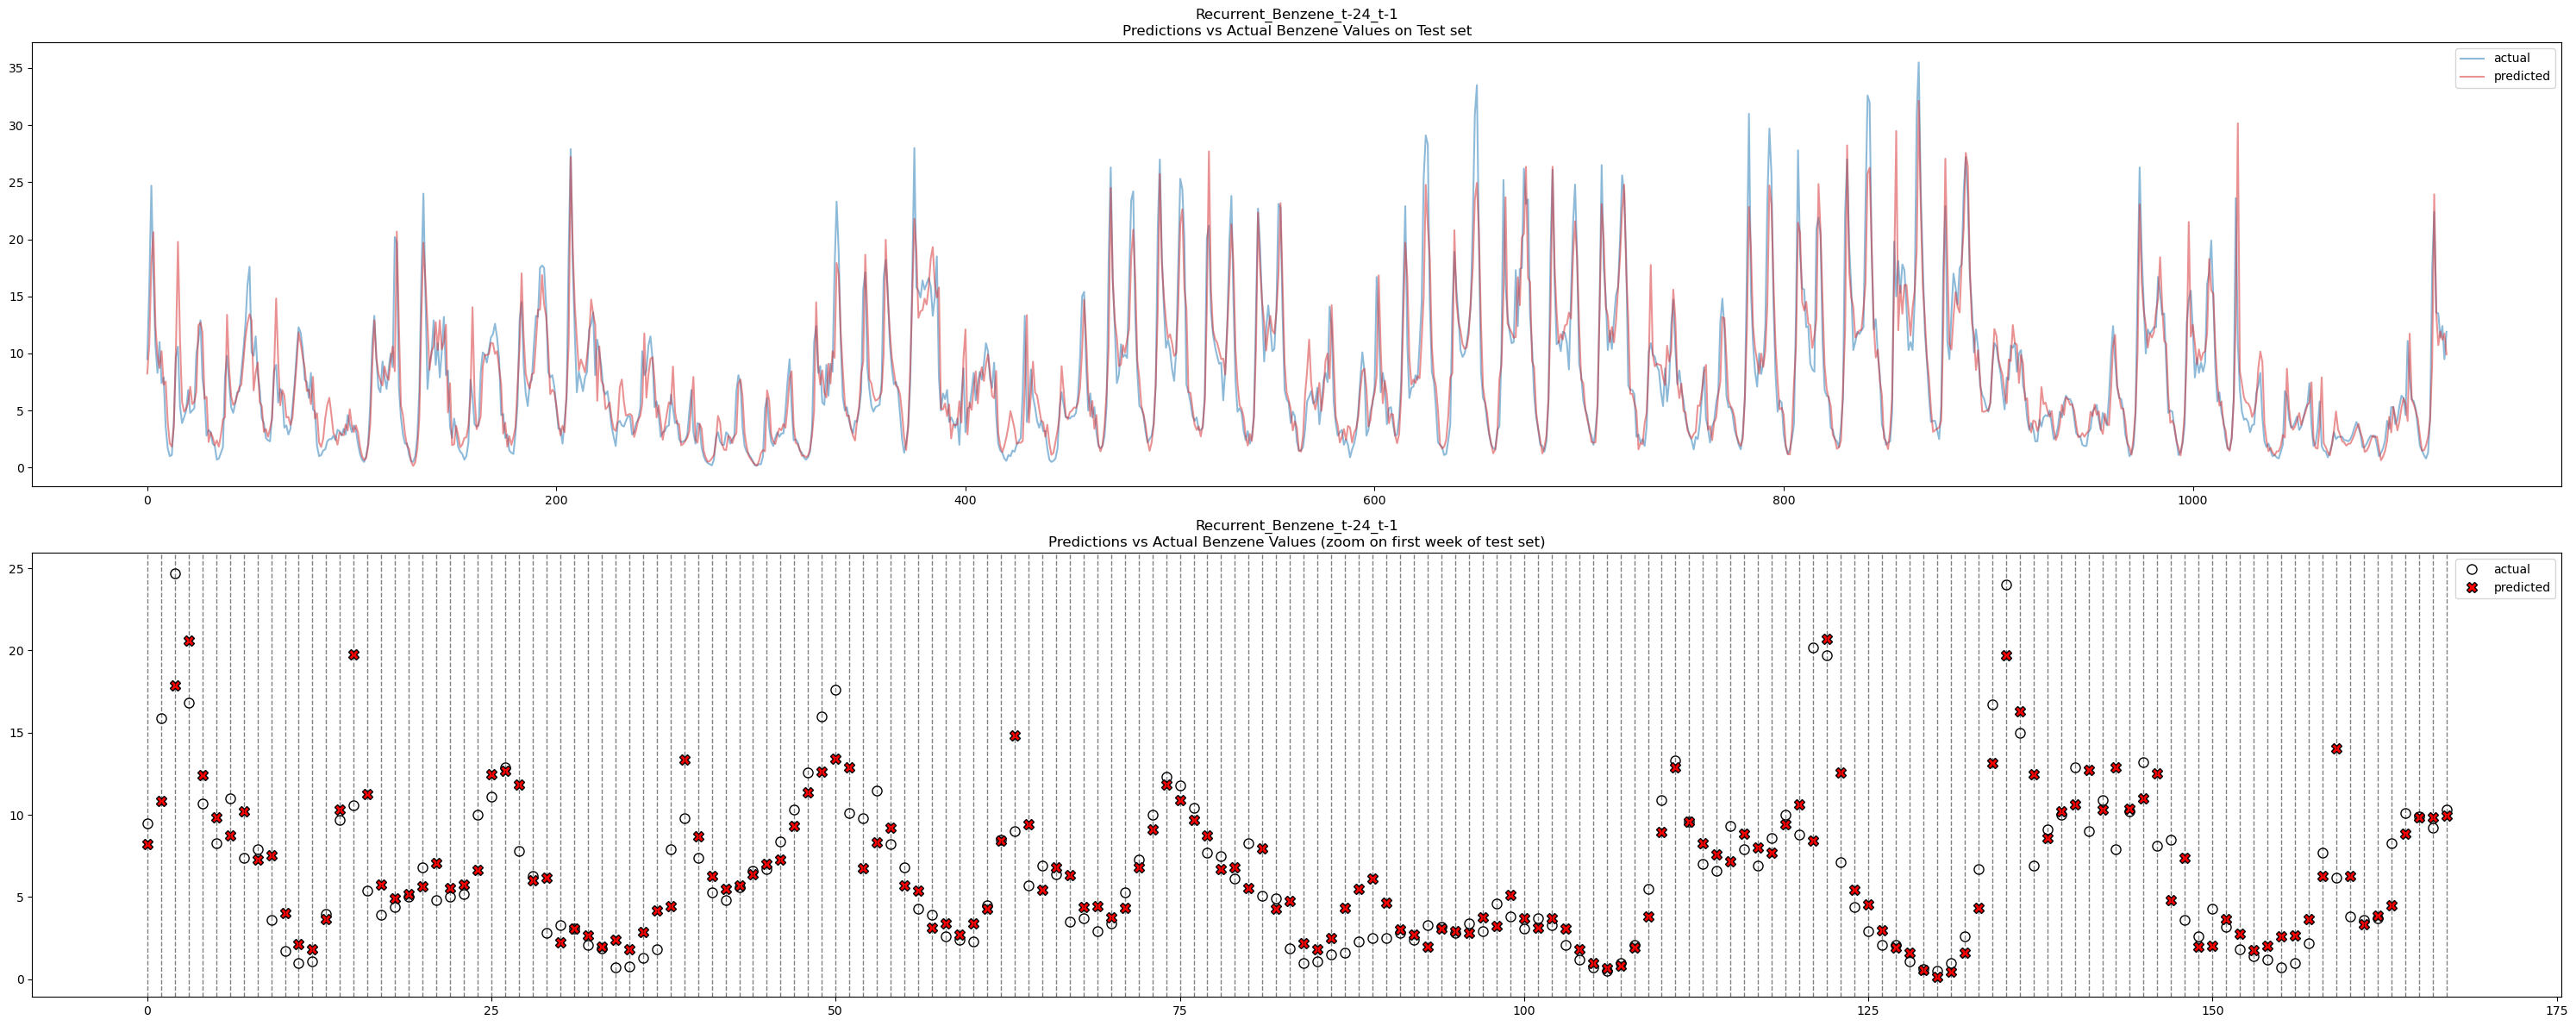

In [50]:
test_predictions = model.predict(X_benzene_test)
plot_test_predictions(true=y_test, predicted=test_predictions, model_name=model_name)

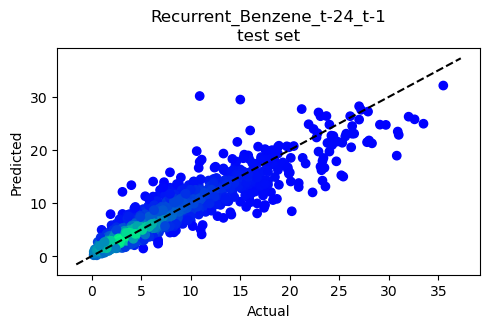

In [51]:
plot_true_vs_predicted(true=y_test.reshape(-1), predicted=test_predictions.reshape(-1), title=model_name+'\ntest set')

The model is not accurate in predicting peaks, as it tends to underestimate the target.

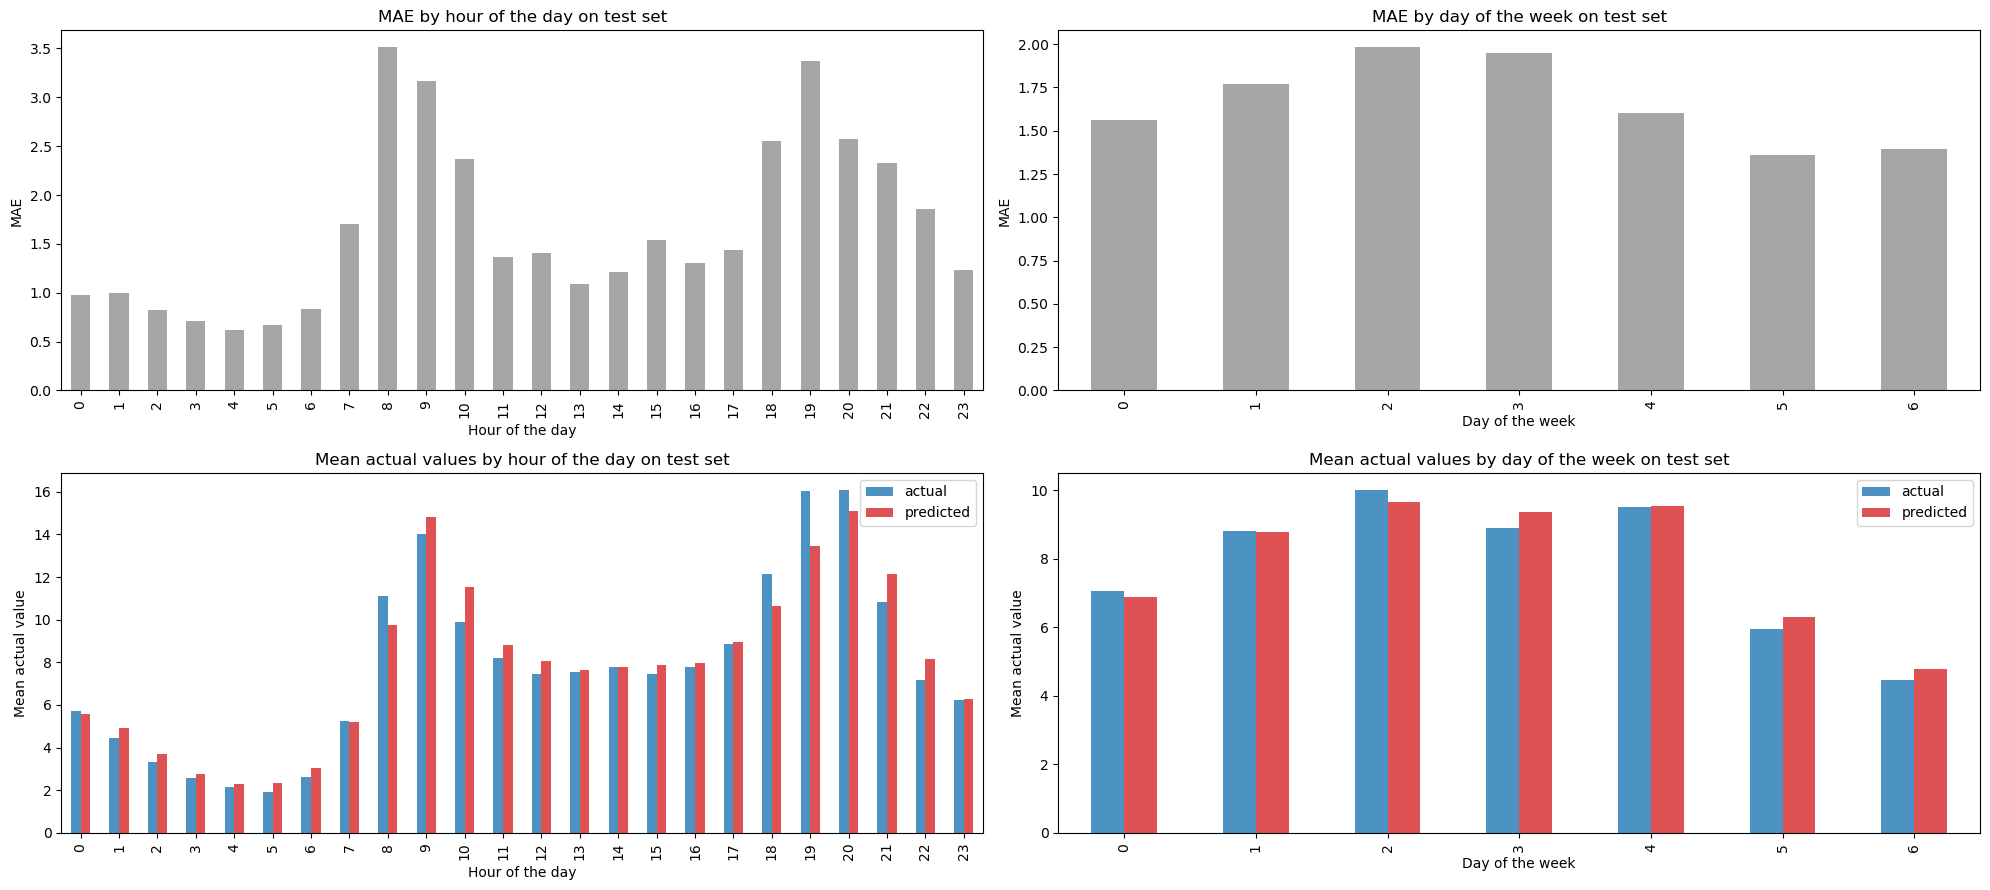

In [52]:
plot_MAE_grouped(y_test.reshape(-1), test_predictions.reshape(-1), test_df.index[24:])

The model underestimates benzene concentration at 8 am and 7 pm, while it overestimates benzene at 9 am. Mean actual and predicted values grouped by hour and day of week are closer than with the previous approach.

I will now test the model on the first week of the test set, giving it in input its own predictions:

In [53]:
preds = list(X_benzene_test[0])
scaler_benzene.feature_names_in_ = None # to avoid warnings
for _ in range(24*7):
    pred = model.predict(np.array(preds[-24:]).reshape(1, 24, 1), verbose=False)
    pred_scaled = scaler_benzene.transform(pred)
    preds.append(pred_scaled[0])

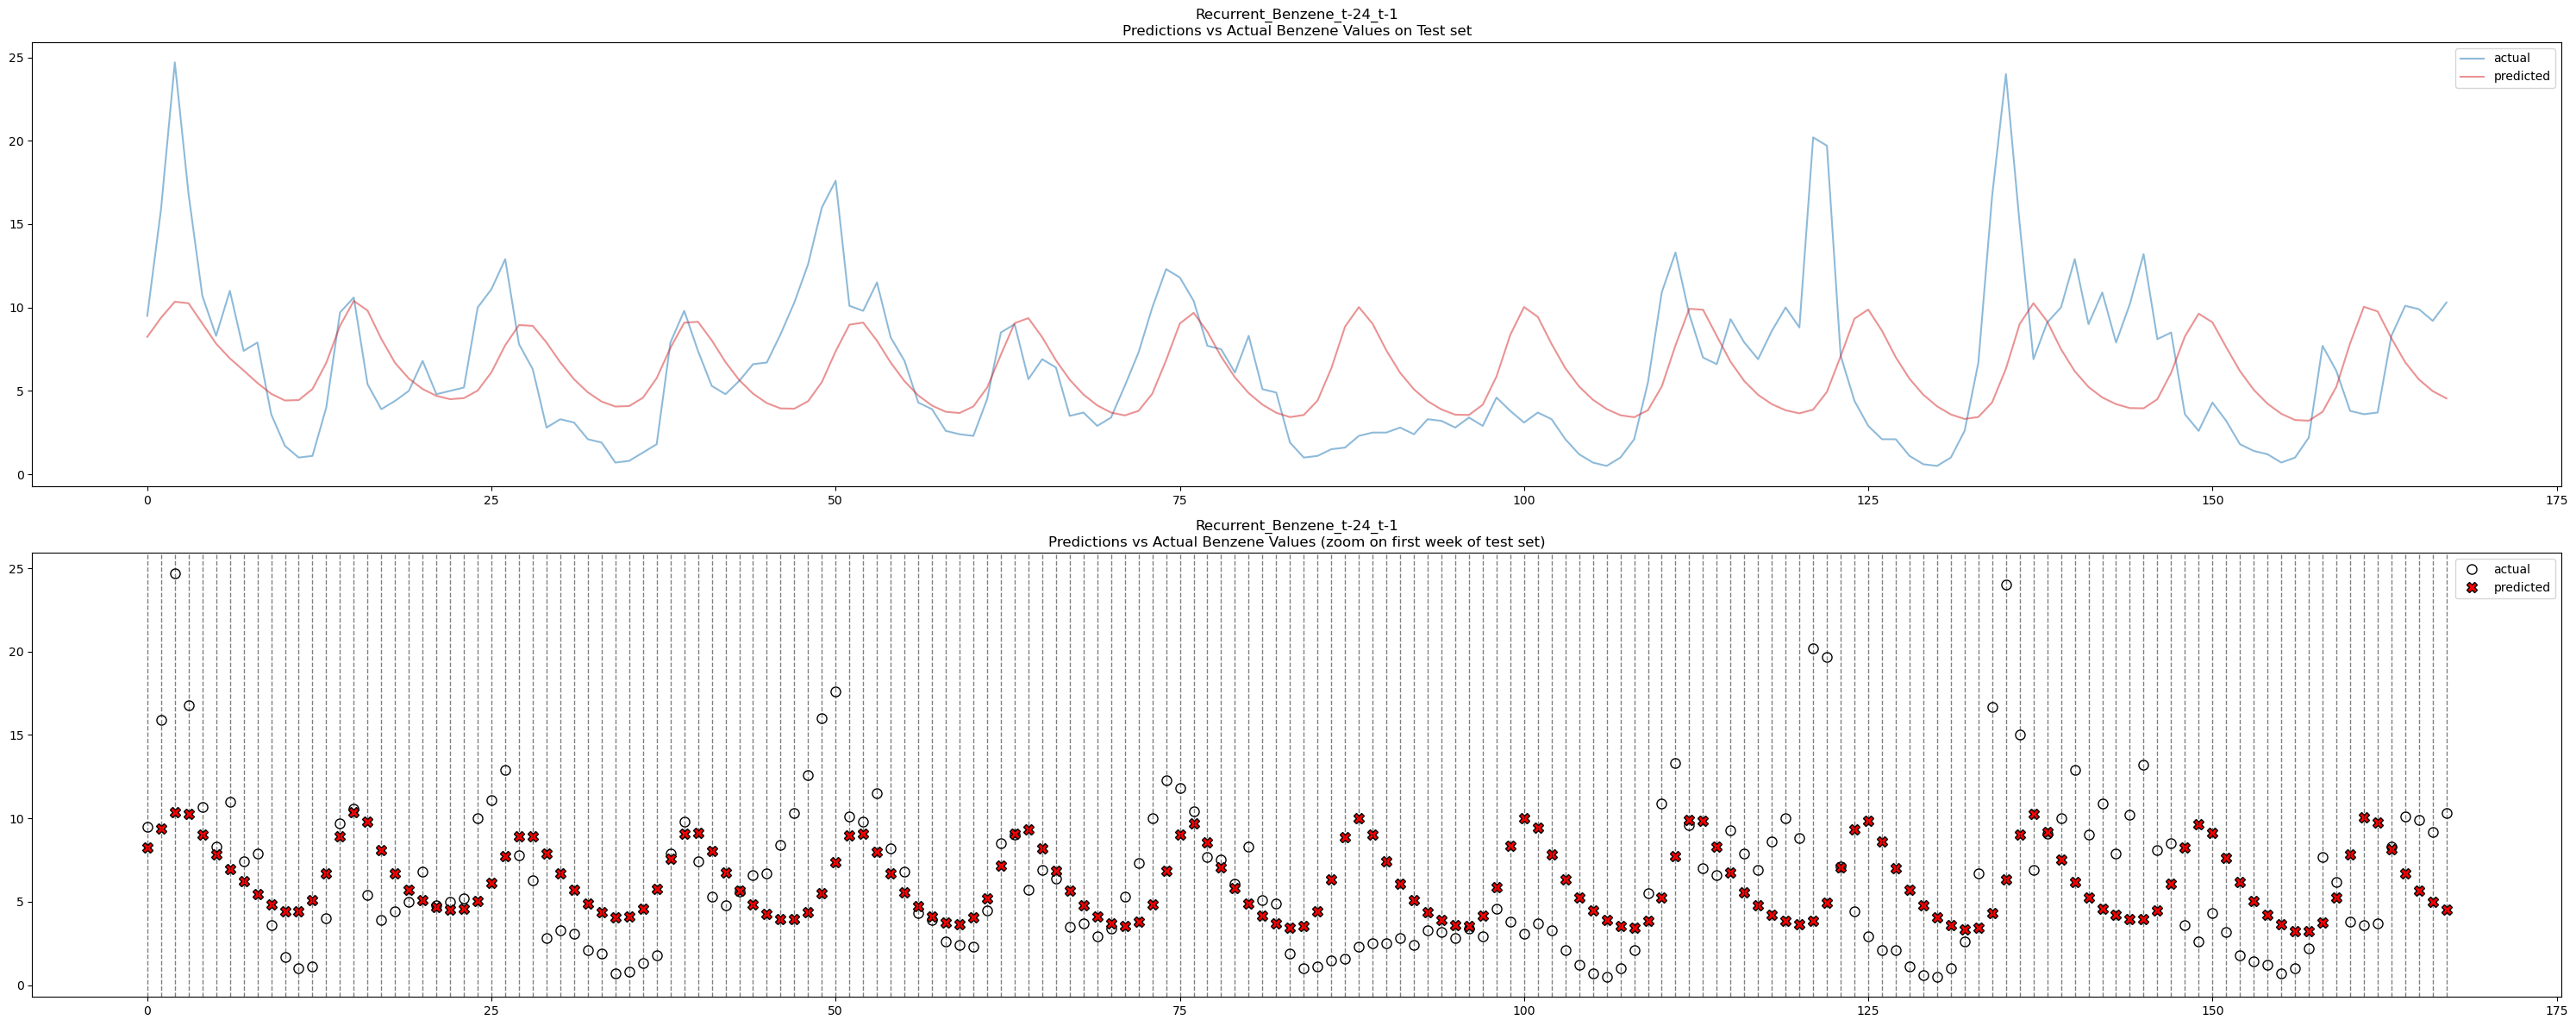

In [54]:
plot_test_predictions(true=y_test[:24*7], predicted=scaler_benzene.inverse_transform(np.array(preds[24:])), model_name=model_name)

Using the model for multi-step predictions leads to poor results. Clearly, once the model makes an incorrect prediction, feeding this prediction as input causes subsequent predictions to be adversely affected.

## Comparing sensor-based and benzene-based models

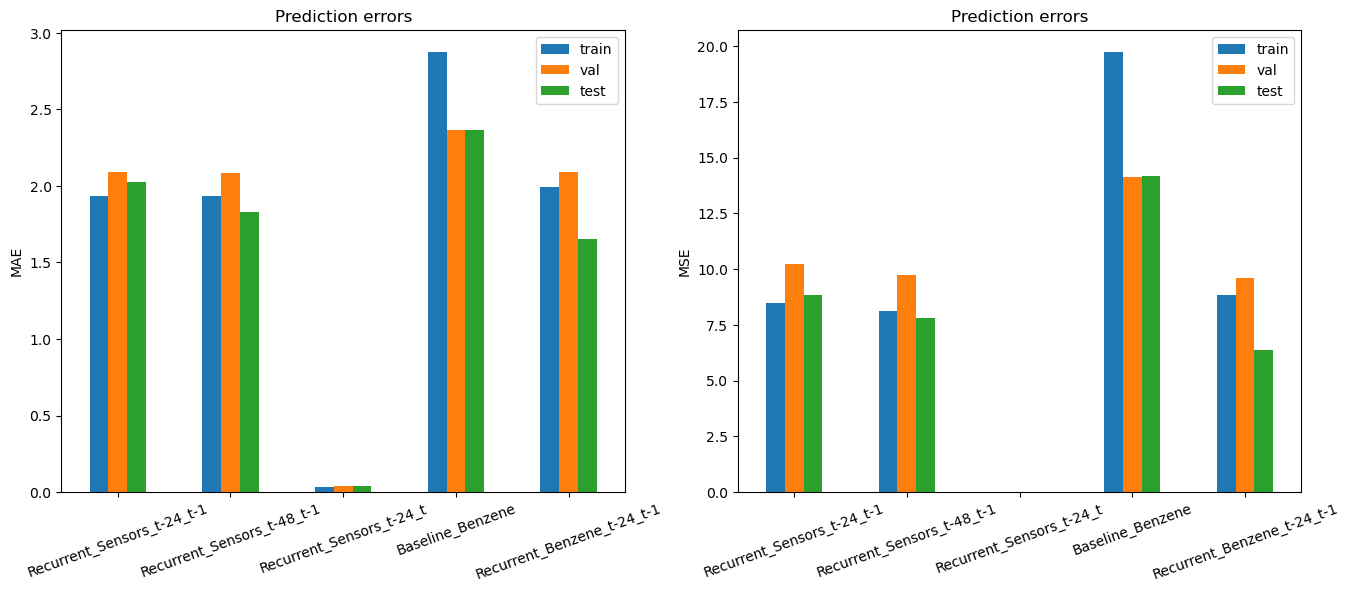

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
pd.DataFrame(results).T[['train_mae', 'val_mae', 'test_mae']].plot(kind='bar', rot=20, ax=axs[0])
axs[0].legend(labels=['train', 'val', 'test'])
axs[0].set_title('Prediction errors')
axs[0].set_ylabel('MAE')
pd.DataFrame(results).T[['train_loss', 'val_loss', 'test_loss']].plot(kind='bar', rot=20, ax=axs[1])
axs[1].legend(labels=['train', 'val', 'test'])
axs[1].set_title('Prediction errors')
axs[1].set_ylabel('MSE');

As previously mentioned, the model using sensor measurements up to the current hour achieves the best performance. The other models exhibit comparable performance. The model using benzene measurements at the previous time step as input, demonstrates better generalization to the test set.

Displaying the performance of the models sorted by mean absolute error on the validation set:

In [56]:
results_df = pd.DataFrame(results).T[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]
results_df.sort_values(by=['val_mae'])

train_mae   val_mae  test_mae train_loss  \
Recurrent_Sensors_t-24_t    0.033147  0.037205  0.042555   0.007919   
Recurrent_Sensors_t-48_t-1   1.93701  2.083809  1.826876    8.11711   
Recurrent_Benzene_t-24_t-1  1.994757  2.091826  1.653127   8.851442   
Recurrent_Sensors_t-24_t-1  1.934353  2.093378  2.023213   8.478454   
Baseline_Benzene            2.874717  2.365111    2.3624  19.731617   

                             val_loss  test_loss  
Recurrent_Sensors_t-24_t     0.002656   0.002903  
Recurrent_Sensors_t-48_t-1   9.740392   7.815091  
Recurrent_Benzene_t-24_t-1   9.608165   6.354577  
Recurrent_Sensors_t-24_t-1  10.241204   8.826072  
Baseline_Benzene            14.121139  14.163723

Inspecting best architectures:

In [57]:
pd.DataFrame(results).T[['params']]

params
Recurrent_Sensors_t-24_t-1   {'units': 40, 'gated_model': 'LSTM', 'stack_2_layers': True}
Recurrent_Sensors_t-48_t-1   {'units': 50, 'gated_model': 'GRU', 'stack_2_layers': False}
Recurrent_Sensors_t-24_t     {'units': 50, 'gated_model': 'LSTM', 'stack_2_layers': True}
Baseline_Benzene                                                                       {}
Recurrent_Benzene_t-24_t-1  {'units': 50, 'gated_model': 'LSTM', 'stack_2_layers': False}

The best model architecture changes depending on the task setting.

## Evaluation of non recurrent models

I will also compare recurrent models with 2-layer feedforward neural networks, using windows of 24 time steps (25 when using the current sensors measurements).

### Predicting Benzene at time t from Sensors measurements at time [t-24, t] with a feedforward neural network

Preparing the data:

In [58]:
X_sensors_curr_train_flat = X_sensors_curr_train.reshape(-1, X_sensors_curr_train.shape[1]*X_sensors_curr_train.shape[2])
X_sensors_curr_val_flat = X_sensors_curr_val.reshape(-1, X_sensors_curr_val.shape[1]*X_sensors_curr_val.shape[2])
X_sensors_curr_test_flat = X_sensors_curr_test.reshape(-1, X_sensors_curr_test.shape[1]*X_sensors_curr_test.shape[2])

print(f"X_sensors_curr_train_flat shape: {X_sensors_curr_train_flat.shape}")
print(f"X_sensors_curr_val_flat shape: {X_sensors_curr_val_flat.shape}")
print(f"X_sensors_curr_test_flat shape: {X_sensors_curr_test_flat.shape}")

X_sensors_curr_train_flat shape: (6360, 125)
X_sensors_curr_val_flat shape: (1800, 125)
X_sensors_curr_test_flat shape: (1125, 125)


The hyperparameters to be tuned include the number of units in each layer (30, 40 or 50), and the activation function (ReLU or tanh).

Building the model:

In [59]:
def build(hp):
    # hyperparameters
    units = hp.Int(name='units', min_value=30, max_value=50, step=10)
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    init = tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)
    # model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=units, activation=activation, kernel_initializer=init))
    model.add(tf.keras.layers.Dense(units=1, activation='linear', kernel_initializer=init))
    model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['mae'])
    return model

Running grid search:

In [60]:
tuner_dense_sensors = kt.GridSearch(
    build,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner_dense_sensors.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [61]:
tuner_dense_sensors.search(
    X_sensors_curr_train_flat,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_sensors_curr_val_flat, y_val),
    callbacks=[early_stopping, tensorboard_callback],
)

Trial 6 Complete [00h 00m 03s]
val_loss: 2.990816831588745

Best val_loss So Far: 0.6947695016860962
Total elapsed time: 00h 00m 23s


In [62]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8430), started 0:31:24 ago. (Use '!kill 8430' to kill it.)

In [63]:
get_traials_df(tuner_dense_sensors)

The best model includes a hidden layer with 40 units and ReLU activation function.

Getting best model:

In [64]:
model_name = 'Dense_Sensors_t-24_t'
models_names.append(model_name)
results[model_name] = {}
model = tuner_dense_sensors.get_best_models()[0]
results[model_name]['fitted_model'] = model
model.build((None, X_sensors_curr_train_flat.shape[1]))
results[model_name]['params'] = tuner_dense_sensors.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Dense_Sensors_t-24_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                5040      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 5,081
Trainable params: 5,081
Non-trainable params: 0
_________________________________________________________________


Evaluating the model:

In [65]:
scores = evaluate_model(
    model,
    X_train=X_sensors_curr_train_flat, y_train=y_train,
    X_val=X_sensors_curr_val_flat, y_val=y_val,
    X_test=X_sensors_curr_test_flat, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 272us/step - loss: 1.0587 - mae: 0.8753


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1  \
train_mae                    1.934353                    1.93701   
val_mae                      2.093378                   2.083809   
test_mae                     2.023213                   1.826876   
train_loss                   8.478454                    8.11711   
val_loss                    10.241204                   9.740392   
test_loss                    8.826072                   7.815091   

           Recurrent_Sensors_t-24_t Baseline_Benzene  \
train_mae                  0.033147         2.874717   
val_mae                    0.037205         2.365111   
test_mae                   0.042555           2.3624   
train_loss                 0.007919        19.731617   
val_loss                   0.002656        14.121139   
test_loss                  0.002903        14.163723   

           Recurrent_Benzene_t-24_t-1 Dense_Sensors_t-24_t  
train_mae                    1.994757             0.318682  
val_mae                      2.091826             0.644496  
test_mae                     1.653127             0.875285  
train_loss                   8.851442             0.180395  
val_loss                     9.608165              0.69477  
test_loss                    6.354577             1.058715

36/36 [==============================] - 0s 323us/step


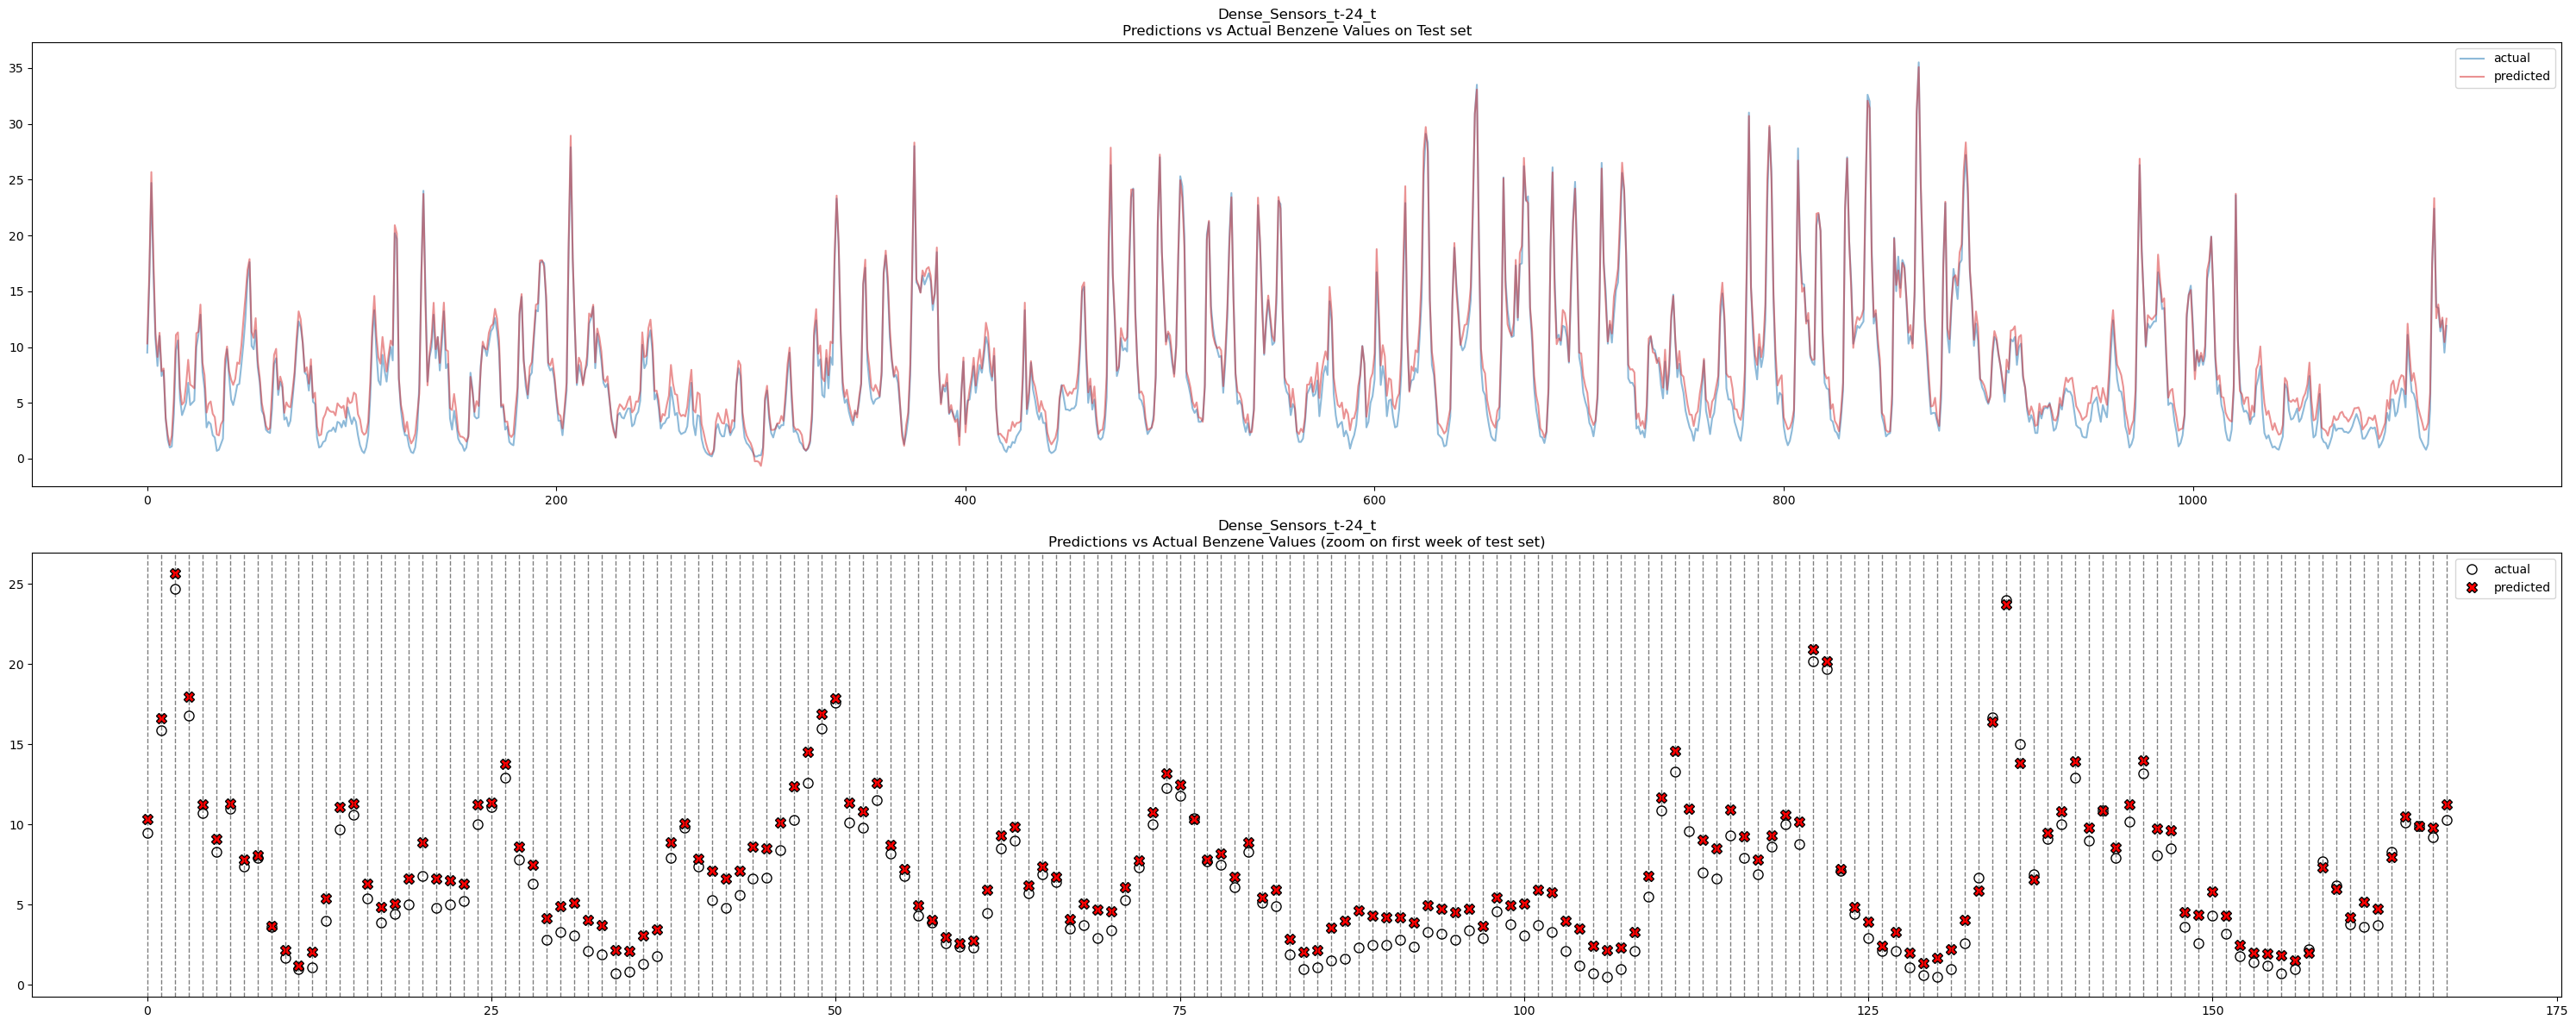

In [66]:
test_predictions = model.predict(X_sensors_curr_test_flat)
plot_test_predictions(true=y_test, predicted=test_predictions, model_name=model_name)

The model predictions depart from the actual values when the target exhibits low values.

### Predicting Benzene at time t from Benzene at time [t-24, t-1] with a feedforward neural network

Preparing the data:

In [67]:
X_benzene_train_flat = X_benzene_train.reshape(-1, X_benzene_train.shape[1]*X_benzene_train.shape[2])
X_benzene_val_flat = X_benzene_val.reshape(-1, X_benzene_val.shape[1]*X_benzene_val.shape[2])
X_benzene_test_flat = X_benzene_test.reshape(-1, X_benzene_test.shape[1]*X_benzene_test.shape[2])

print(f"X_benzene_train_flat shape: {X_benzene_train_flat.shape}")
print(f"X_benzene_val_flat shape: {X_benzene_val_flat.shape}")
print(f"X_benzene_test_flat shape: {X_benzene_test_flat.shape}")

X_benzene_train_flat shape: (6360, 24)
X_benzene_val_flat shape: (1800, 24)
X_benzene_test_flat shape: (1125, 24)


Running grid search:

In [68]:
tuner_dense_benzene = kt.GridSearch(
    build,
    objective='val_loss',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner_dense_benzene.search(
    X_benzene_train_flat,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_data=(X_benzene_val_flat, y_val),
    callbacks=[early_stopping, tensorboard_callback],
)


Trial 6 Complete [00h 00m 04s]
val_loss: 10.039778709411621

Best val_loss So Far: 9.656513214111328
Total elapsed time: 00h 00m 28s


Inspecting grid search results:

In [69]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8430), started 0:32:10 ago. (Use '!kill 8430' to kill it.)

In [70]:
get_traials_df(tuner_dense_benzene)

The best model includes a hidden layer with 30 units and ReLU activation function.

Getting best model:

In [71]:
model_name = 'Dense_Benzene_t-24_t-1'
models_names.append(model_name)
results[model_name] = {}
model = tuner_dense_benzene.get_best_models()[0]
results[model_name]['fitted_model'] = model
model.build((None, X_benzene_train_flat.shape[1]))
results[model_name]['params'] = tuner_dense_benzene.get_best_hyperparameters()[0].values
model._name = model_name
model.summary()

Model: "Dense_Benzene_t-24_t-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                750       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


Evaluating the model:

In [72]:
scores = evaluate_model(
    model,
    X_train=X_benzene_train_flat, y_train=y_train,
    X_val=X_benzene_val_flat, y_val=y_val,
    X_test=X_benzene_test_flat, y_test=y_test
)
results[model_name].update(scores)
pd.DataFrame(results).loc[['train_mae', 'val_mae', 'test_mae', 'train_loss', 'val_loss', 'test_loss']]

36/36 [==============================] - 0s 275us/step - loss: 6.7853 - mae: 1.7879


Recurrent_Sensors_t-24_t-1 Recurrent_Sensors_t-48_t-1  \
train_mae                    1.934353                    1.93701   
val_mae                      2.093378                   2.083809   
test_mae                     2.023213                   1.826876   
train_loss                   8.478454                    8.11711   
val_loss                    10.241204                   9.740392   
test_loss                    8.826072                   7.815091   

           Recurrent_Sensors_t-24_t Baseline_Benzene  \
train_mae                  0.033147         2.874717   
val_mae                    0.037205         2.365111   
test_mae                   0.042555           2.3624   
train_loss                 0.007919        19.731617   
val_loss                   0.002656        14.121139   
test_loss                  0.002903        14.163723   

           Recurrent_Benzene_t-24_t-1 Dense_Sensors_t-24_t  \
train_mae                    1.994757             0.318682   
val_mae                      2.091826             0.644496   
test_mae                     1.653127             0.875285   
train_loss                   8.851442             0.180395   
val_loss                     9.608165              0.69477   
test_loss                    6.354577             1.058715   

           Dense_Benzene_t-24_t-1  
train_mae                2.065206  
val_mae                  2.117866  
test_mae                 1.787878  
train_loss               9.151717  
val_loss                 9.656513  
test_loss                6.785314

36/36 [==============================] - 0s 309us/step


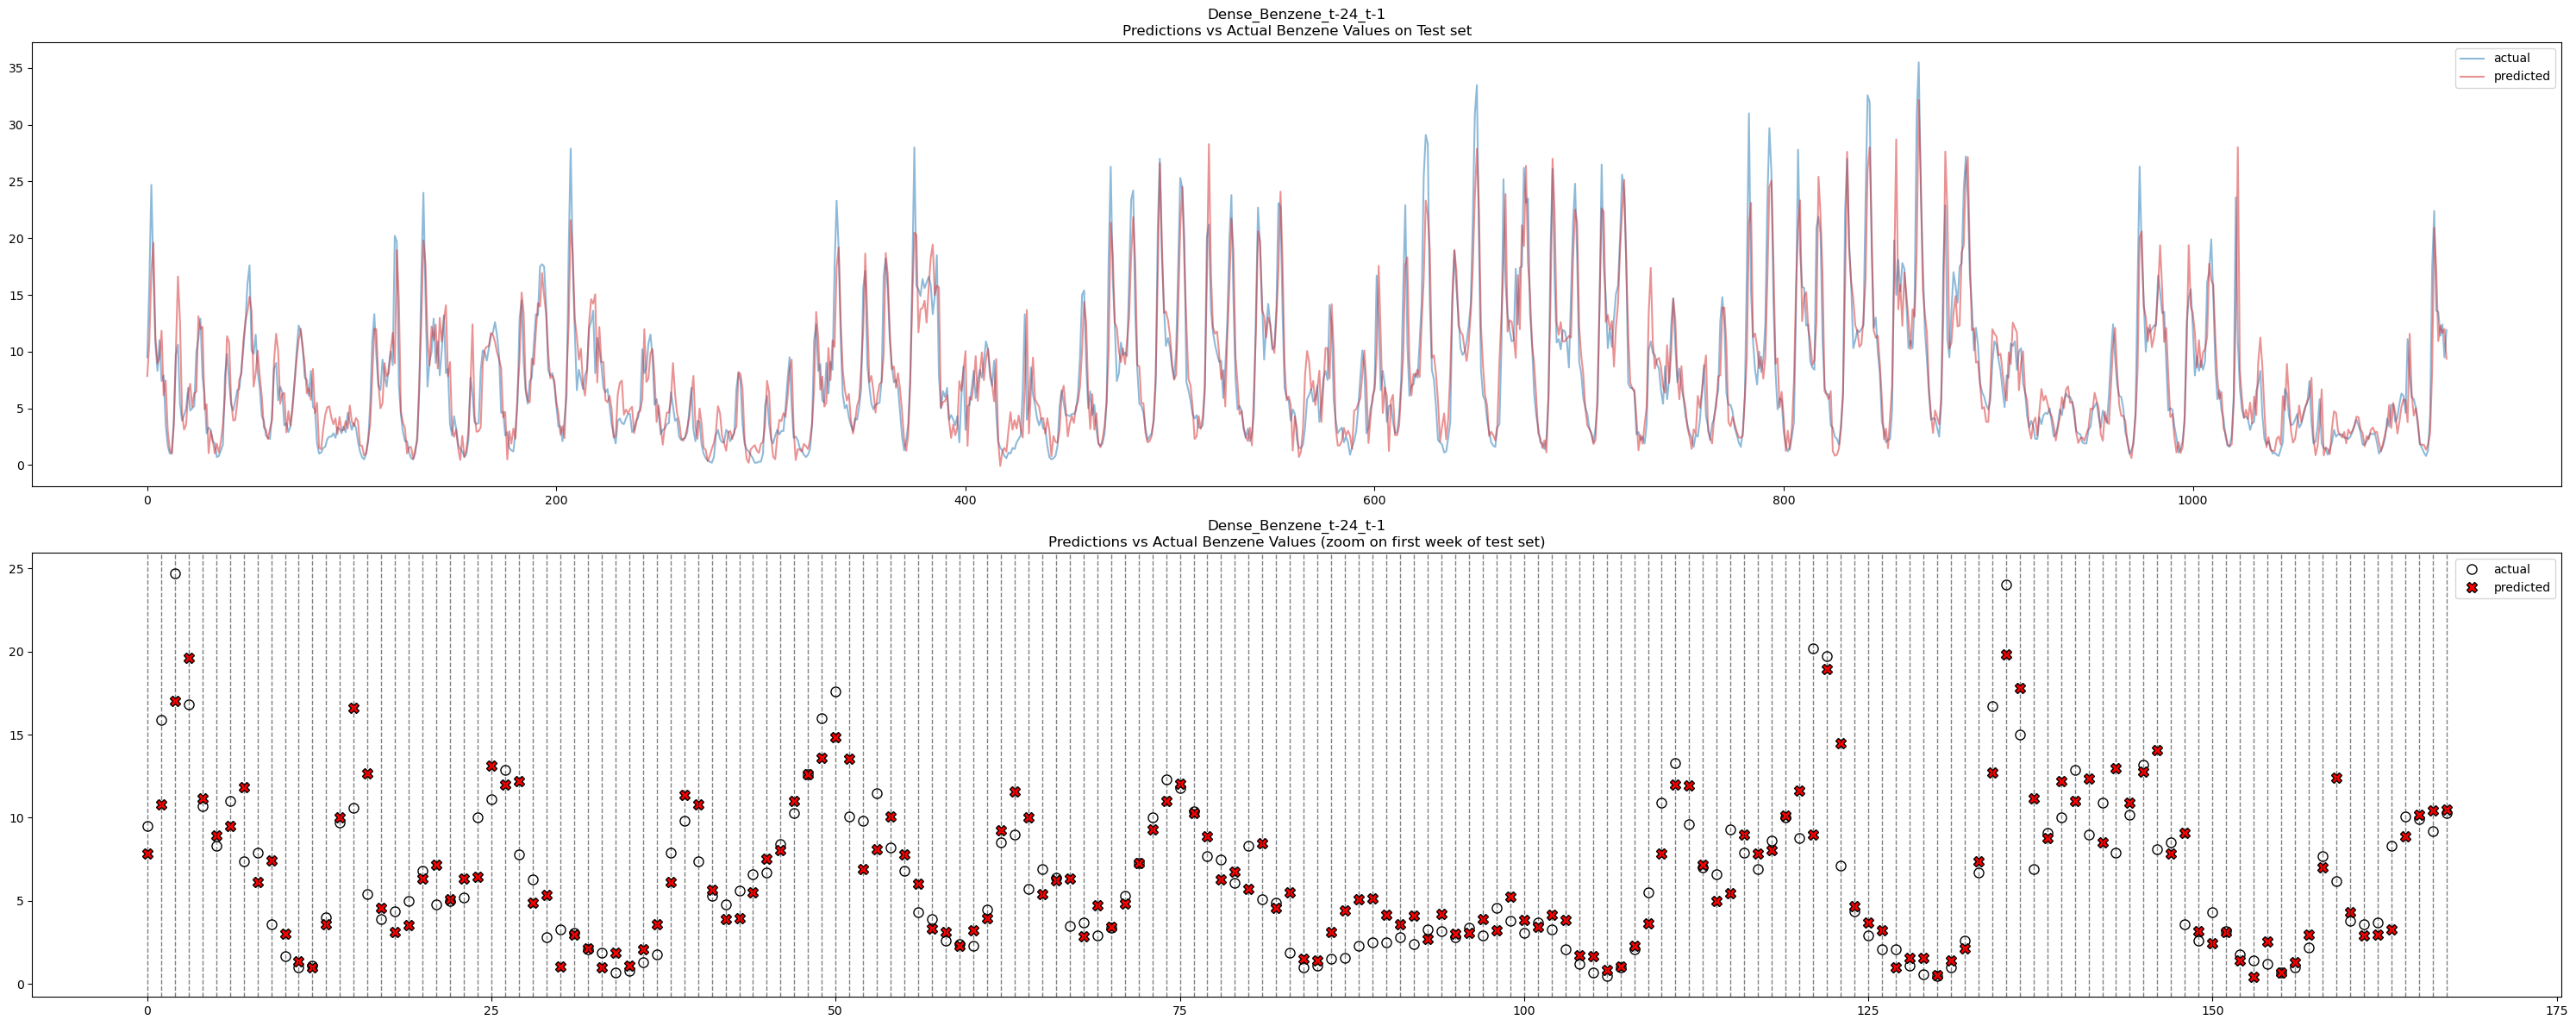

In [73]:
test_predictions = model.predict(X_benzene_test_flat)
plot_test_predictions(true=y_test, predicted=test_predictions, model_name=model_name)

## Comparing recurrent and non-recurrent models

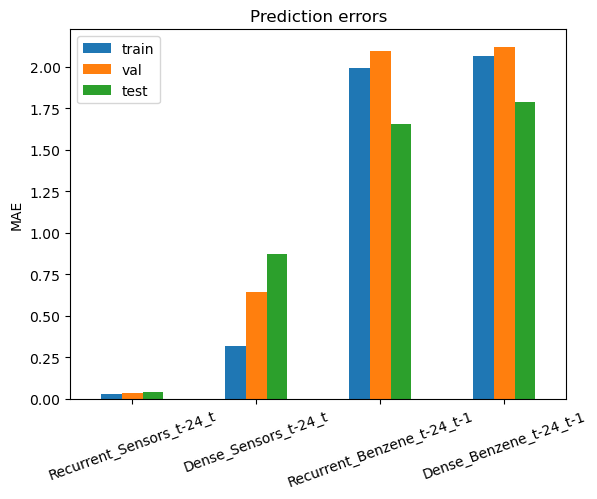

In [74]:
pd.DataFrame(results).T[['train_mae', 'val_mae', 'test_mae']].loc[
    ['Recurrent_Sensors_t-24_t', 'Dense_Sensors_t-24_t', 'Recurrent_Benzene_t-24_t-1', 'Dense_Benzene_t-24_t-1']].plot(kind='bar', rot=20)
plt.legend(labels=['train', 'val', 'test'])
plt.title('Prediction errors')
plt.ylabel('MAE');

When using sensor measurements up to the current hour, the recurrent models outperform the feedforward neural networks. In the setting where the benzene concentration at the previous time step is used as input, recurrent and non-recurrent models exhibit comparable performance, but the recurrent models generalize better to the test set.

## Autoregressive model for multistep prediction

I will now model the supervised learning task as a regression problem, where the target is the Benzene concentration at the next 24 time steps (multistep prediction) and each sample is a sequence of the last 24 benzene measurements. 

Preparing the data:

In [75]:
def create_dataset_multi_step(X, y, time_steps=1, shift=1):
    Xs, ys = [], []
    for i in range(0, X.shape[0] - 2*time_steps + 1, shift):
        xi = X[i:(i + time_steps)]
        Xs.append(xi)
        yi = y[(i + time_steps):(i + 2*time_steps)]
        ys.append(yi)
    return np.array(Xs), np.array(ys)

In [76]:
X_benzene_multi_train, y_multi_train = create_dataset_multi_step(benzene_train, benzene_train, time_steps=24, shift=24)
X_benzene_multi_val, y_multi_val = create_dataset_multi_step(benzene_val, benzene_val, time_steps=24, shift=24)
X_benzene_multi_test, y_multi_test = create_dataset_multi_step(benzene_test, benzene_test, time_steps=24, shift=24)

print(f"X_benzene_train shape: {X_benzene_multi_train.shape}, y_train shape: {y_multi_train.shape}")
print(f"X_benzene_val shape: {X_benzene_multi_val.shape}, y_val shape: {y_multi_val.shape}")
print(f"X_benzene_test shape: {X_benzene_multi_test.shape}, y_test shape: {y_multi_test.shape}")

X_benzene_train shape: (265, 24, 1), y_train shape: (265, 24, 1)
X_benzene_val shape: (75, 24, 1), y_val shape: (75, 24, 1)
X_benzene_test shape: (46, 24, 1), y_test shape: (46, 24, 1)


For simplicity, the model will predict scaled values (targets are scaled too).

To produce multistep predictions, I will use an autoregressive model, where the model's output is fed back into itself at each step:

![alt text](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

The implementation of the following model was taken from the [TensorFlow tutorial on time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#rnn_3).

In [77]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

I will use a single LSTM layer with 50 units, and the Adam optimizer with a learning rate of 1e-3:

In [78]:
model = FeedBack(units=50, out_steps=24)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model.build((None, X_benzene_multi_train.shape[1], X_benzene_multi_train.shape[2]))
model.summary()

Model: "feed_back"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell (LSTMCell)        multiple                  10400     
                                                                 
 rnn (RNN)                   multiple                  10400     
                                                                 
 dense_2 (Dense)             multiple                  51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Fitting the model:

In [79]:
h = model.fit(
    X_benzene_multi_train,
    y_multi_train,
    validation_data=(X_benzene_multi_val, y_multi_val),
    epochs=500,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
9/9 [==============================] - 2s 39ms/step - loss: 0.9513 - mae: 0.7556 - val_loss: 0.8359 - val_mae: 0.7373
Epoch 2/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8965 - mae: 0.7274 - val_loss: 0.8020 - val_mae: 0.7107
Epoch 3/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8858 - mae: 0.7219 - val_loss: 0.8017 - val_mae: 0.7128
Epoch 4/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8833 - mae: 0.7223 - val_loss: 0.7895 - val_mae: 0.7073
Epoch 5/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8819 - mae: 0.7223 - val_loss: 0.7866 - val_mae: 0.7074
Epoch 6/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8701 - mae: 0.7171 - val_loss: 0.7821 - val_mae: 0.7054
Epoch 7/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8616 - mae: 0.7125 - val_loss: 0.7768 - val_mae: 0.7031
Epoch 8/500
9/9 [==============================] - 0s 8ms/step - loss: 0.8448 - mae: 0.7062 - va

Evaluating the model:

In [80]:
train_predictions = model.predict(X_benzene_multi_train)
train_predictions_inv = scaler_benzene.inverse_transform(train_predictions.reshape(-1, 24))

val_predictions = model.predict(X_benzene_multi_val)
val_predictions_inv = scaler_benzene.inverse_transform(val_predictions.reshape(-1, 24))

test_predictions = model.predict(X_benzene_multi_test)
test_predictions_inv = scaler_benzene.inverse_transform(test_predictions.reshape(-1, 24))

train_mae = mean_absolute_error(scaler_benzene.inverse_transform(y_multi_train.reshape(-1, 24)), train_predictions_inv)
val_mae = mean_absolute_error(scaler_benzene.inverse_transform(y_multi_val.reshape(-1, 24)), val_predictions_inv)
test_mae = mean_absolute_error(scaler_benzene.inverse_transform(y_multi_test.reshape(-1, 24)), test_predictions_inv)

pd.DataFrame({'train_mae': train_mae, 'val_mae': val_mae, 'test_mae': test_mae}, index=[model_name])

2/2 [==============================] - 0s 2ms/step


train_mae   val_mae  test_mae
Dense_Benzene_t-24_t-1   3.780018  4.172514  3.458941

Plotting the predictions for the first week of the test set:

2/2 [==============================] - 0s 3ms/step


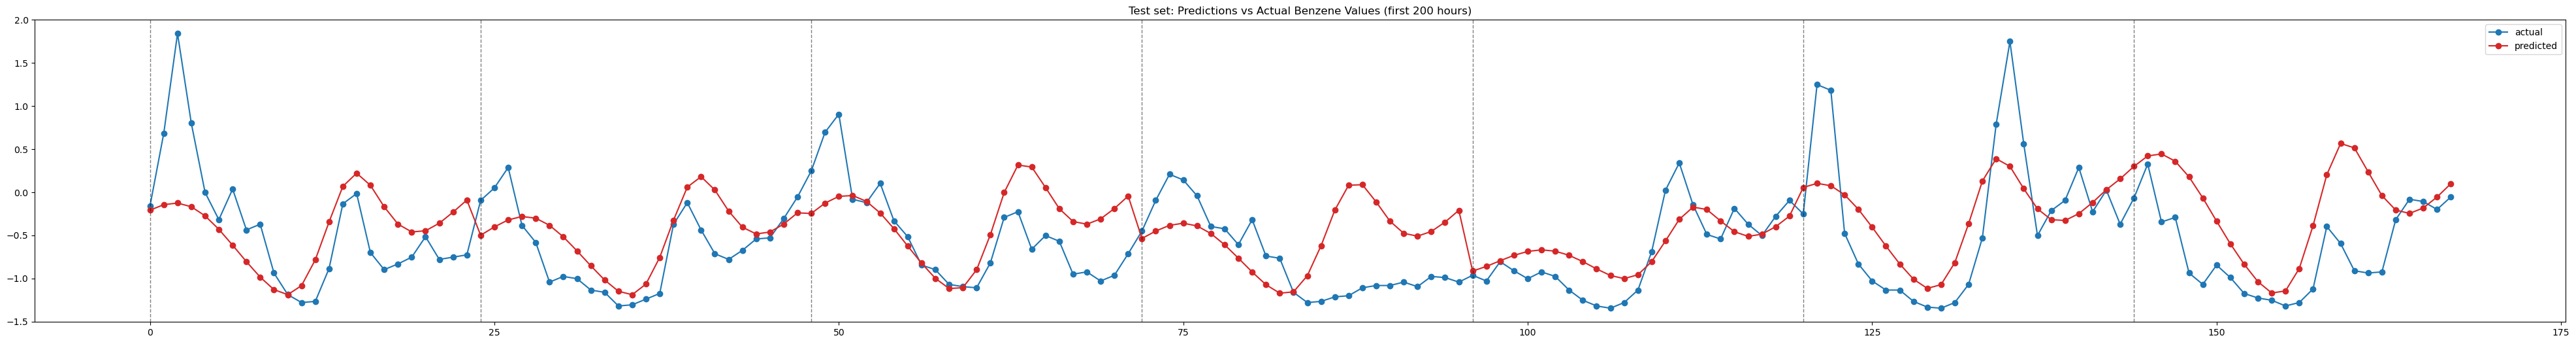

In [81]:
test_predictions = model.predict(X_benzene_multi_test)
fig, axs = plt.subplots(1, figsize=(50, 6), sharey=False)
df = pd.DataFrame(data={'actual': y_multi_test.flatten()[:24*7], 'predicted': test_predictions.flatten()[:24*7]})
df.plot(ax=axs, style='-o', color=['tab:blue', 'tab:red'])
for i in range(0, 24*7, 24):
    axs.axvline(i, color='black', linestyle='--', linewidth=1, alpha=0.5)
axs.set_title("Test set: Predictions vs Actual Benzene Values (first 200 hours)");

The model's predictions are generally inaccurate, but the model successfully captures the daily patterns in the data.

## Conclusion

- The setting that achieves the best performance is the one where the model uses sensor measurements up to the current hour to predict the Benzene concentration at the same hour. This is expected, as sensors and target measurements are highly correlated. The model using as features the sensor measurements up to the previous hour and the one using the target at the previous time steps exhibit comparable performance, but the latter generalizes better to the test set. 

- The performance of the recurrent models (LSTM/GRU, single and multi-layer) is quite similar on the same task.

- Using 48 time steps instead of 24 does not result in significant improvements.

- When using sensor measurements up to the current hour, recurrent models outperform feedforward neural networks. When using benzene measurements, recurrent and non-recurrent models exhibit comparable performance, but the recurrent model generalizes better to the test set.

- The autoregressive model for multistep prediction performs poorly.

### Possible improvements

- Performing feature selection to identify the most relevant sensors for the task.
- Using as features both sensor measurements and the target at the previous time steps.
- Experimenting with dropout (i.e. `dropout ` and `recurrent_dropout` parameters in the keras LSTM/GRU layers) to prevent overfitting and units co-adaptation.